## 분석 준비

In [ ]:
# 한글깨짐 방지(코랩)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
# 분석을 위한 라이브러리
import numpy as np
import pandas as pd
import re
import math

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('seaborn')   # 그래프 스타일
#sns.set_style('whitegrid')  # 그래프 스타일
plt.rc('font', family='NanumbarunGothic')

# 에러메세지 안나오게
import warnings
warnings.filterwarnings('ignore')

# ML
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
#파일 업로드
from google.colab import files
files.upload()

Saving vgames2.csv to vgames2 (1).csv


{'vgames2.csv': b'"","Name","Platform","Year","Genre","Publisher","NA_Sales","EU_Sales","JP_Sales","Other_Sales"\n"1","Candace Kane\'s Candy Factory","DS","2008","Action","Destineer","0.04","0","0","0"\n"2","The Munchables","Wii","2009","Action","Namco Bandai Games","0.17","0","0","0.01"\n"3","Otome wa Oanesama Boku ni Koi Shiteru Portable","PSP","2010","Adventure","Alchemist","0","0","0.02","0"\n"4","Deal or No Deal: Special Edition","DS","2010","Misc","Zoo Games","0.04","0","0","0"\n"5","Ben 10 Ultimate Alien: Cosmic Destruction","PS3","2010","Platform","D3Publisher","0.12","0.09","0","0.04"\n"6","Power Pro Kun Pocket 8","DS","2005","Sports","Konami Digital Entertainment","0","0","0.14","0"\n"7","JASF: Jane\'s Advanced Strike Fighters","PC","2011","Simulation","Deep Silver","0.02","0.01","0","0"\n"8","Samurai Warriors: State of War","PSP","2005","Action","Tecmo Koei","0.07","0","0.11","0.01"\n"9","Imabikisou","PS3","2007","Adventure","Sega","0","0","0.04","0"\n"10","The Penguins of M

In [3]:
data = pd.read_csv('/content/vgames2.csv',index_col=0)
data
df=data.copy()

## columns info

- Name : 게임의 이름입니다.
- Platform : 게임이 지원되는 플랫폼의 이름입니다.
- Year : 게임이 출시된 연도입니다.
- Genre : 게임의 장르입니다.
- Publisher : 게임을 배급한 회사입니다.
- NA_Sales : 북미지역에서의 출고량입니다.
- EU_Sales : 유럽지역에서의 출고량입니다.
- JP_Sales : 일본지역에서의 출고량입니다.
- Other_Sales : 기타지역에서의 출고량입니다.

In [4]:
df.shape

(16598, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 1 to 16598
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.3+ MB


In [6]:
display(df.describe(include='object'), df.describe())

,Name,Platform,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
count,16598,16598,16548,16540,16598,16598,16598,16598
unique,11493,31,12,578,494,363,282,190
top,Need for Speed: Most Wanted,DS,Action,Electronic Arts,0,0,0,0
freq,12,2163,3305,1351,4443,5665,10333,6386


,Year
count,16327.000000
mean,1994.242543
std,155.077168
min,0.000000
25%,2003.000000
50%,2007.000000
75%,2010.000000
max,2020.000000


In [7]:
df.isnull().sum()

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

- Year는 실수형이 아닌 정수형으로 변경해준다.
- Year의 경우 nan값이 71개로 결측치 처리 후에 타입 변환.
- Genre, Publisher의 결측치 처리
- NA_Sales, EU_Sales, JP_Sales, Other_Sales 은 object가 아닌 float으로 데이터 타입 변경.데이터에 문자열이 없는지 체크하고 타입변환.

## 결측치 처리 & 타입 변환 & 이상치 처리 & 중복값

In [8]:
# genre 결측치 비율 = 0.3%
df.Genre.value_counts()

len(df[df.Genre.isnull()]) / len(df)

0.003012411133871551

In [9]:
# Year 결측치 비율 = 16%
df.Year.value_counts() 
len(df[df.Year.isnull()]) / len(df)

0.016327268345583804

In [10]:
# Publisher 결측치 비율 = 0.3%
df.Publisher.value_counts() 
len(df[df.Publisher.isnull()]) / len(df)

0.003494396915290999

In [11]:
# genre, publisher, year 결측치 drop
# genre, publisher는 결측치 비율이 낮아서 drop하지만, year의 경우 16%이다.
# Year의 평균값이나 최빈값을 넣거나, 그룹을 지어서 그룹의 평균값을 넣으려고 했지만,
# 어떤 그룹으로 묶냐에 따라서도 결과가 달라지기 때문에 과감히 drop

df.dropna(subset=['Genre','Publisher','Year'],inplace=True)

In [12]:
df = df.reset_index(drop=True)

In [13]:
# 연도는 실수형이 아닌 정수형으로변경.
df.Year = df.Year.astype(int)

In [14]:
df.isnull().sum()

Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16241 entries, 0 to 16240
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         16241 non-null  object
 1   Platform     16241 non-null  object
 2   Year         16241 non-null  int64 
 3   Genre        16241 non-null  object
 4   Publisher    16241 non-null  object
 5   NA_Sales     16241 non-null  object
 6   EU_Sales     16241 non-null  object
 7   JP_Sales     16241 non-null  object
 8   Other_Sales  16241 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.1+ MB


In [16]:
# 출고량 컬럼들 단위 맞춰주기
df[df['NA_Sales'].str.contains(r"[a-zA-Z]")==True]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
10,Ford Racing,PS,2001,Racing,Empire Interactive,480K,0.33M,0K,0.06
44,Resident Evil: Revelations 2,PS3,2015,Action,Capcom,60K,0.08,0.16,0.03
142,TOCA Race Driver 3,PC,2006,Racing,Codemasters,0K,0.02,0,0
439,Medal of Honor: Warfighter,X360,2012,Action,Electronic Arts,0.58M,0.47,0.01,0.1
450,F1 2010,PS3,2010,Racing,Codemasters,0.25M,0.76,0.08,0.27
...,...,...,...,...,...,...,...,...,...
15978,Midway Arcade Treasures,PS2,2003,Misc,Midway Games,720K,0.56,0,0.19
16056,NASCAR 06: Total Team Control,PS2,2005,Racing,Electronic Arts,0.53M,0.02,0,0.09
16127,Super Robot Taisen F Kanketsuhen,SAT,98,Strategy,Banpresto,0M,0,0.55,0
16137,Mortal Kombat,PSV,2012,Fighting,Warner Bros. Interactive Entertainment,470K,0.18,0,0.12


In [17]:
#단위가 k인 경우 정수형이고, M인 경우 실수형으로 표현되어있따. 
# M인 경우는 단위를 없애주고, k인경우 0.001을 곱해 단위 맞춰준다.

df['NA_Sales'] = df['NA_Sales'].replace({'[kK]': '*0.001', '[mM]': ''}, regex=True).map(pd.eval).astype(float)
df['EU_Sales'] = df['EU_Sales'].replace({'[kK]': '*0.001', '[mM]': ''}, regex=True).map(pd.eval).astype(float)
df['JP_Sales'] = df['JP_Sales'].replace({'[kK]': '*0.001', '[mM]': ''}, regex=True).map(pd.eval).astype(float)
df['Other_Sales'] = df['Other_Sales'].replace({'[kK]': '*0.001', '[mM]': ''}, regex=True).map(pd.eval).astype(float)

In [18]:
df.describe()

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales
count,16241.000000,16241.000000,16241.000000,16241.000000,16241.000000
mean,1994.178437,0.265195,0.147378,0.078283,0.048234
std,155.484265,0.822431,0.508340,0.309272,0.189678
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000
75%,2010.000000,0.240000,0.110000,0.040000,0.040000
max,2020.000000,41.490000,29.020000,10.220000,10.570000


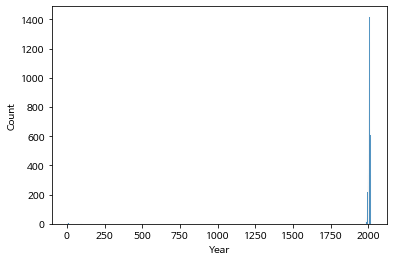

In [19]:
sns.histplot(df.Year)

In [20]:
df[df.Year<1750].Year.describe()

# 연도가 20이하면 2000, 그 외에는 1900을 더해준다.

count    100.000000
mean      20.470000
std       30.671098
min        0.000000
25%        6.000000
50%        9.000000
75%       14.000000
max       98.000000
Name: Year, dtype: float64

In [21]:
df[df.Year<100]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
72,Age of Empires III: Complete Collection,PC,9,Strategy,Microsoft Game Studios,0.01,0.12,0.00,0.03
79,Treasures of the Deep,PS,97,Action,Namco Bandai Games,0.10,0.07,0.00,0.01
210,NASCAR Unleashed,PS3,11,Racing,Activision,0.09,0.00,0.00,0.01
299,Kung Fu Panda: Showdown of Legendary Legends,PS3,15,Action,Little Orbit,0.00,0.02,0.00,0.00
758,NASCAR Thunder 2004,PS2,3,Racing,Electronic Arts,0.53,0.41,0.00,0.14
...,...,...,...,...,...,...,...,...,...
15641,Sugoi Hebereke,SNES,94,Fighting,Sunsoft,0.00,0.00,0.02,0.00
15756,Fab 5 Soccer,DS,8,Sports,Destineer,0.01,0.00,0.00,0.00
15801,Dragon Ball Z: Burst Limit,X360,8,Fighting,Atari,0.24,0.18,0.03,0.05
16042,Point Blank 3,PS,0,Shooter,Namco Bandai Games,0.01,0.01,0.00,0.00


In [22]:
# 연도 2자리에서 4자리로 바꾸기
for i in range(20):
  df.loc[df['Year'] == i, 'Year'] = 2000+i
df.loc[df['Year'] < 100, 'Year'] += 1900

In [23]:
#중복값
df.duplicated().sum()

0

## EDA, Data Wrangling

### 장르

In [24]:
# Sales total 컬럼 추가

df['Sales_total'] = df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales']

In [ ]:
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Sales_total
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25
...,...,...,...,...,...,...,...,...,...,...
16236,Ice Age 2: The Meltdown,GC,2006,Platform,Vivendi Games,0.15,0.04,0.00,0.01,0.20
16237,Rainbow Islands: Revolution,PSP,2005,Action,Rising Star Games,0.01,0.00,0.00,0.00,0.01
16238,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0.79
16239,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,0.05,0.05,0.25,0.03,0.38


In [ ]:
df.describe()

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Sales_total
count,16241.000000,16241.000000,16241.000000,16241.000000,16241.000000,16241.000000
mean,2006.406748,0.265195,0.147378,0.078283,0.048234,0.539091
std,5.832087,0.822431,0.508340,0.309272,0.189678,1.563905
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.040000,0.480000
max,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000


In [ ]:
# 게임 이름.
df.Name.value_counts(),df.Name.value_counts(normalize=True)

(Need for Speed: Most Wanted    12
 LEGO Marvel Super Heroes        9
 Ratatouille                     9
 FIFA 14                         9
 LEGO Jurassic World             8
                                ..
 Pokemon Ranger                  1
 Virtual Soccer                  1
 Neighborhood Games              1
 Nonomura Byoin no Hitobito      1
 Rainbow Islands: Revolution     1
 Name: Name, Length: 11295, dtype: int64,
 Need for Speed: Most Wanted    0.000739
 LEGO Marvel Super Heroes       0.000554
 Ratatouille                    0.000554
 FIFA 14                        0.000554
 LEGO Jurassic World            0.000493
                                  ...   
 Pokemon Ranger                 0.000062
 Virtual Soccer                 0.000062
 Neighborhood Games             0.000062
 Nonomura Byoin no Hitobito     0.000062
 Rainbow Islands: Revolution    0.000062
 Name: Name, Length: 11295, dtype: float64)

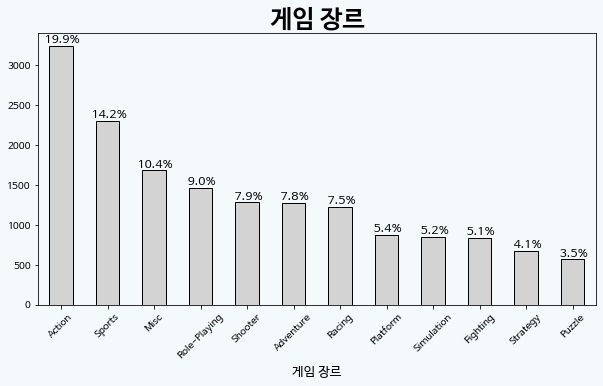

In [27]:
# 장르
plt.figure(figsize=(10,5),facecolor='#F4F9FC')
p=df.Genre.value_counts().plot(kind='bar',rot=45,color='lightgray',edgecolor='Black')
plt.title('게임 장르',fontsize=25,fontweight='bold')
p.set_facecolor(color='#F4F9FC')
df.Genre.value_counts(normalize=True)
plt.xlabel('게임 장르', fontsize=13)
# Action 19%, sports 14% 차지

for patch in p.patches:
  p.text(x=patch.get_x() + patch.get_width()/2 ,y=patch.get_height()+40, s=f'{(patch.get_height()/len(df))*100 : 1.1f}%', ha='center',size=12)

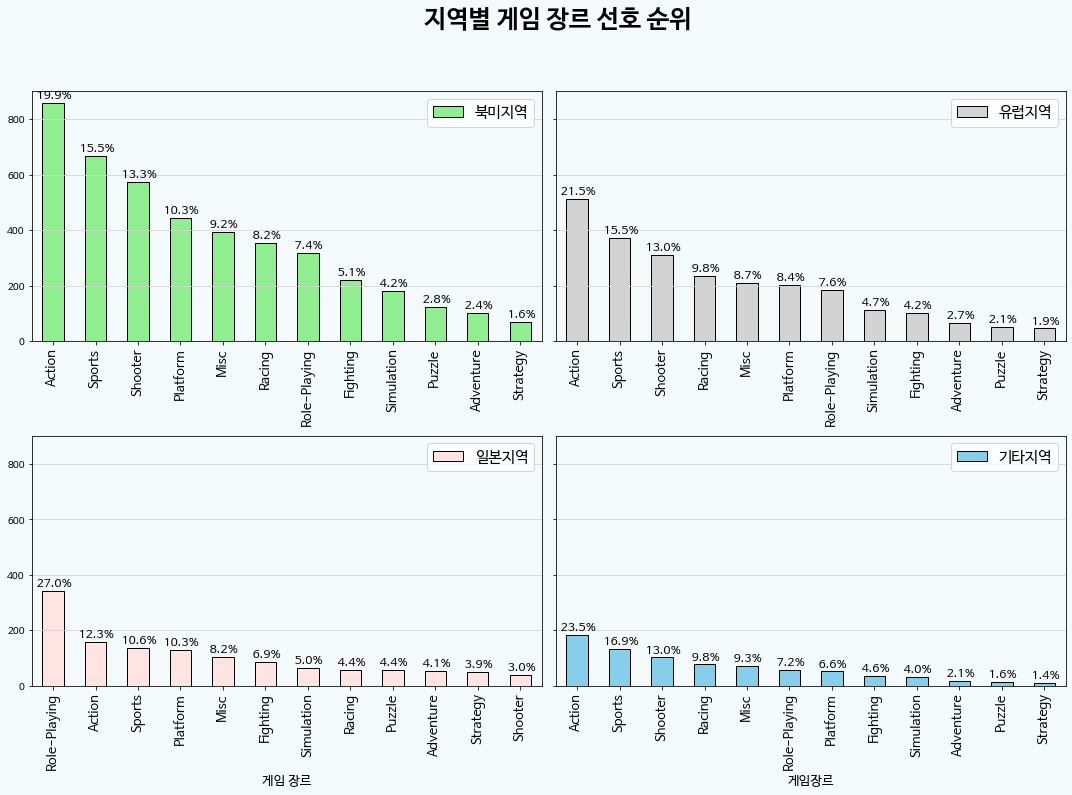

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10),sharey=True, facecolor='#F4F9FC')

plt.suptitle('지역별 게임 장르 선호 순위',fontsize=25,fontweight='bold',x=0.52,y=1.1)


NA = df.groupby('Genre').NA_Sales.sum().sort_values(ascending=False).plot(kind='bar',ax=axes[0,0],edgecolor='black',color='lightgreen')
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=90, fontsize=13)
# axes[0,0].set_title('북미지역',fontsize=20,fontweight='bold')
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('')
axes[0,0].set_facecolor(color='#F4F9FC')
axes[0,0].grid(True, axis='y',color='lightgray')
axes[0,0].legend(labels=['북미지역'],fontsize=15,loc='best')
for patch in NA.patches:
  axes[0,0].text(x=patch.get_x() + patch.get_width()/2 ,y=patch.get_height() + len(df)*0.001,s=f'{(patch.get_height()/df.NA_Sales.sum())*100 : 1.1f}%', ha='center',size=12)
  


EU = df.groupby('Genre').EU_Sales.sum().sort_values(ascending=False).plot(kind='bar',ax=axes[0,1],edgecolor='black',color='lightgray')
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=90, fontsize=13)
# axes[0,1].set_title('유럽지역',fontsize=20,fontweight='bold')
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')
axes[0,1].set_facecolor(color='#F4F9FC')
axes[0,1].grid(True, axis='y',color='lightgray')
axes[0,1].legend(labels=['유럽지역'],fontsize=15,loc='best')
for patch in EU.patches:
  axes[0,1].text(x=patch.get_x() + patch.get_width()/2 ,y=patch.get_height() + len(df)*0.001, s=f'{(patch.get_height()/df.EU_Sales.sum())*100 : 1.1f}%', ha='center',size=12)
  

JP = df.groupby('Genre').JP_Sales.sum().sort_values(ascending=False).plot(kind='bar',ax=axes[1,0],edgecolor='black',color='mistyrose')
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=90, fontsize=13)
# axes[1,0].set_title('일본지역',fontsize=20,fontweight='bold')
axes[1,0].set_xlabel('게임 장르',fontsize=13)
axes[1,0].set_ylabel('')
axes[1,0].set_facecolor(color='#F4F9FC')
axes[1,0].grid(True, axis='y',color='lightgray')
axes[1,0].legend(labels=['일본지역'],fontsize=15,loc='best')
for patch in JP.patches:
  axes[1,0].text(x=patch.get_x() + patch.get_width()/2 ,y=patch.get_height() + len(df)*0.001,s=f'{(patch.get_height()/df.JP_Sales.sum())*100 : 1.1f}%', ha='center',size=12)
  


OTH = df.groupby('Genre').Other_Sales.sum().sort_values(ascending=False).plot(kind='bar',ax=axes[1,1],edgecolor='black',color='skyblue')
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=90, fontsize=13)
# axes[1,1].set_title('기타지역',fontsize=20,fontweight='bold')
axes[1,1].set_xlabel('게임장르',fontsize=13)
axes[1,1].set_ylabel('')
axes[1,1].set_facecolor(color='#F4F9FC')
axes[1,1].grid(True, axis='y',color='lightgray')
axes[1,1].legend(labels=['기타지역'],fontsize=15,loc='best')
for patch in OTH.patches:
  axes[1,1].text(x=patch.get_x() + patch.get_width()/2 ,y=patch.get_height() + len(df)*0.001, s=f'{(patch.get_height()/df.Other_Sales.sum())*100 : 1.1f}%', ha='center',size=12)


plt.tight_layout()

In [ ]:
# 귀무가설 : 북미, 유럽, 일본, 기타 지역의 장르가 같다.
# 대립가설 : 북미, 유럽, 일본, 기타 지역의 장르가 다르다.

# 독립변수 : 장르 (범주)
# 종속변수 : 출고량(연속)

In [ ]:
ga_na = list(df.groupby(['Genre']).NA_Sales.sum().values)
ga_eu = list(df.groupby('Genre').EU_Sales.sum().values)
ga_jp = list(df.groupby('Genre').JP_Sales.sum().values)
ga_ot = list(df.groupby('Genre').Other_Sales.sum().values)

# 지역별 출고량.

df3 = pd.DataFrame({'na':ga_na, 'eu':ga_eu, 'jp':ga_jp, 'ot':ga_ot}).astype(int)
df2=df3.reset_index().copy()

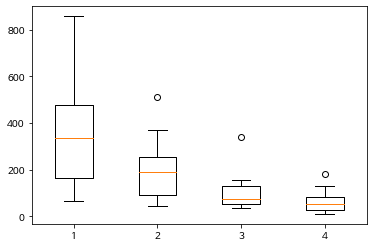

In [ ]:
plt.boxplot([df2.na,df2.eu,df2.jp,df2.ot]);

In [ ]:
df1 = df2.copy()

df1 = pd.melt(df1, id_vars=['index'], value_vars=['na','eu','jp','ot'], var_name='group', value_name='score').drop(labels=['index'], axis=1)
df1.head()

,group,score
0,na,858
1,na,101
2,na,220
3,na,394
4,na,445


In [ ]:
#pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 KB 13.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 62.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pingouin: filename=pingouin-0.5.3-py3-none-any.whl size=198588 sha256=70399c1c56825402cbb6ed3df87501908af8072d473392aecd168713cb4f61fe
  Stored in directory: /root/.cache/pip/wheels/60/1e/21/710be95d0c93ea9ac3c0e6bacd8cce492ad5dd26bf3aedc4bf
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7047 sha256=f106f1613411ec05b3177cfd56772b9fcef33f8646ce82d6510b335677dc597d
  Stored in directory: /root/.cache/pip/wheels/6a/33/c4/0ef84d7f5568c2823e3d63a6e08988852fb9e4bc822034870a
Successfully built pingouin littleuti

In [ ]:
import pingouin as pg
from scipy import stats
pg.homoscedasticity(dv = 'score', group = 'group', data = df1)

# 등분산성 위배.

,W,pval,equal_var
levene,6.428095,0.001048,False


In [ ]:
A = df1[df1['group'] == 'na'].score
B = df1[df1['group'] == 'eu'].score
C = df1[df1['group'] == 'jp'].score
D = df1[df1['group'] == 'ot'].score

li = [A, B, C, D]
for i in li:
  print(stats.shapiro(i).pvalue)

# 귀무가설 : 해당 데이터는 정규성을 충족한다.
# 대립가설 : 해당 데이터는 정규성을 충족하지 않는다.

# 집단 중 하나라도 정규성을 충족하지 않아  Kruskal-Waliis test로 진행

0.46869659423828125
0.22711274027824402
0.0017345078522339463
0.13731136918067932


In [ ]:
# 정규성 가정 X -> Kruskal-Waliis test
s,p=stats.kruskal(A, B, C, D)

In [ ]:
if p<0.05:
  print(p,'대립가설 채택 : 지역별로 선호하는 장르 다르다.')
else : 
  print(p,'귀무가설 채택 : 지역별로 선호하는 장르 같다')

In [ ]:
# 카이제곱
from scipy.stats import chi2_contingency

chi_2, p, dof, expected = chi2_contingency(df3)
msg = 'Test Statistic: {}\np-value: {}\nDegree of Freedom: {}'
print(msg.format(chi_2, p, dof))
print(expected)


if p<0.05:
  print(p,'대립가설 채택 : 지역별로 선호하는 장르 다르다.')
else : 
  print(p,'귀무가설 채택 : 지역별로 선호하는 장르 같다')

Test Statistic: 685.898580683562
p-value: 4.5702026915473273e-123
Degree of Freedom: 33
[[842.26804124 467.55670103 247.97938144 152.19587629]
 [113.78006873  63.16116838  33.49896907  20.55979381]
 [217.70904926 120.85383734  64.0975945   39.3395189 ]
 [383.20733104 212.72462772 112.8233677   69.24467354]
 [406.84994273 225.84902635 119.78419244  73.51683849]
 [117.72050401  65.34856816  34.65910653  21.27182131]
 [355.13172967 197.13940435 104.55738832  64.17147766]
 [442.80641466 245.80904926 130.37044674  80.01408935]
 [503.88316151 279.7137457  148.35257732  91.05051546]
 [190.6185567  105.81546392  56.12164948  34.4443299 ]
 [641.79839633 356.27273769 188.95738832 115.97147766]
 [ 84.22680412  46.7556701   24.79793814  15.21958763]]
4.5702026915473273e-123 대립가설 채택 : 지역별로 선호하는 장르 다르다.


In [33]:
y = df.groupby('Year').size().index
y

pop = []

for i in y:
  pop.append([i,df[df.Year==i]['Genre'].value_counts().index[0],df[df.Year==i]['Genre'].value_counts()[0]])


In [34]:
# 연도별로 인기 있는 게임 장르
pop_frame = pd.DataFrame(pop)
pop_frame.columns = ['연도','인기장르','counts']
pop_frame

,연도,인기장르,counts
0,1980,Misc,4
1,1981,Action,25
2,1982,Action,18
3,1983,Action,7
4,1984,Racing,3
5,1985,Puzzle,4
6,1986,Action,6
7,1987,Sports,4
8,1988,Platform,4
9,1989,Puzzle,5


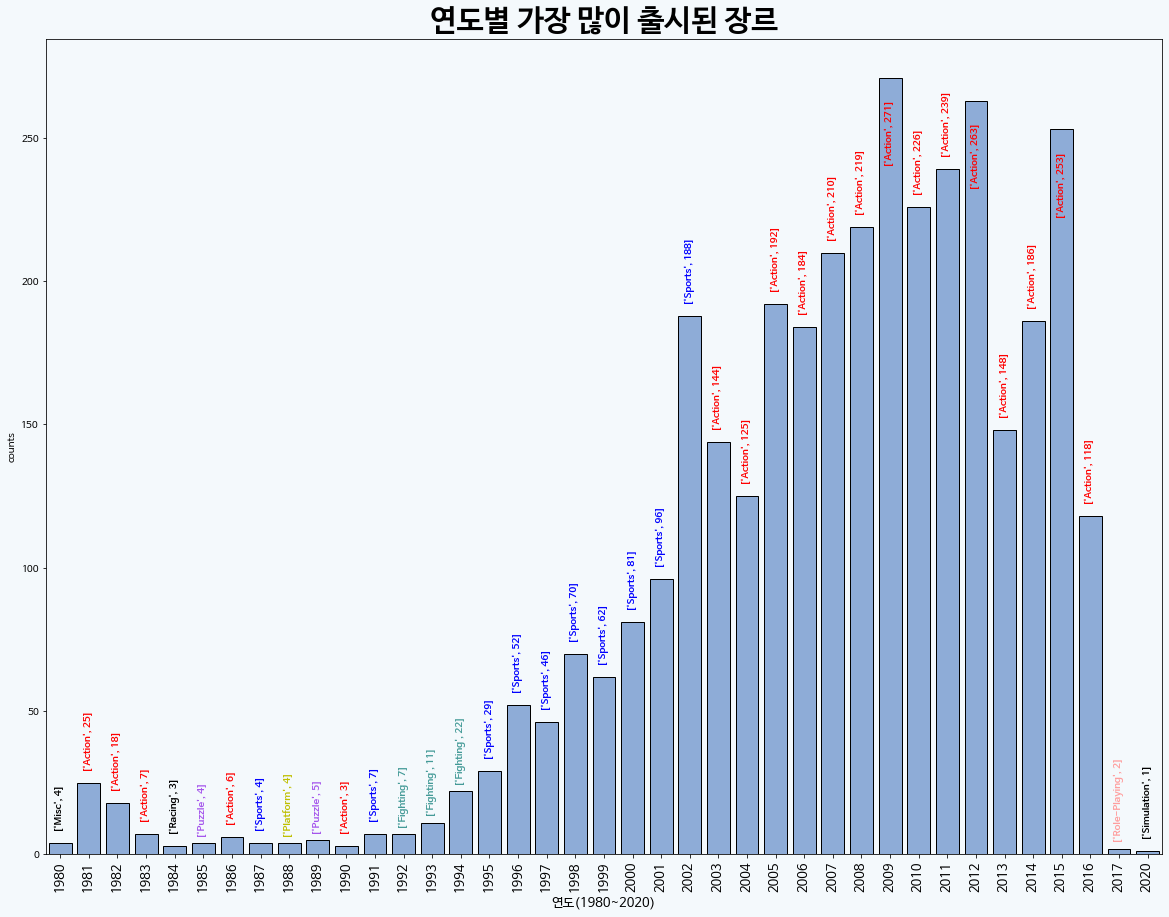

In [35]:
plt.figure(figsize=(20,15),facecolor='#F4F9FC')

year_count = sns.barplot(x=pop_frame.연도,y=pop_frame.counts,color='#82AAE3',edgecolor='black')
year_count.set_xticklabels(year_count.get_xticklabels(), rotation=90, fontsize=13)
year_count.set_title('연도별 가장 많이 출시된 장르',fontsize=30,fontweight='bold')
year_count.set_xlabel('연도(1980~2020)',fontsize=13)
year_count.set_facecolor(color='#F4F9FC')


i=0
for h in year_count.patches:
  if h.get_height() < 250 : 
    if pop[i][1]=='Action':
      year_count.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+5 , s=pop[i][1:3], ha='center',size=12, fontsize=10,color='r',rotation=90,fontweight='bold')
      i+=1
    elif pop[i][1]=='Sports':
      year_count.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+5 , s=pop[i][1:3], ha='center',size=12, fontsize=10,color='b',rotation=90,fontweight='bold')
      i+=1
    elif pop[i][1]=='Platform':
      year_count.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop[i][1:3], ha='center',size=12, fontsize=10,color='y',rotation=90,fontweight='bold')
      i+=1
    elif pop[i][1]=='Puzzle':
      year_count.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop[i][1:3], ha='center',size=12, fontsize=10,color='#A555EC',rotation=90,fontweight='bold')
      i+=1
    elif pop[i][1]=='Fighting':
      year_count.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop[i][1:3], ha='center',size=12, fontsize=10,color='#439A97',rotation=90,fontweight='bold')
      i+=1
    elif pop[i][1]=='Role-Playing':
      year_count.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop[i][1:3], ha='center',size=12, fontsize=10,color='#FF9E9E',rotation=90,fontweight='bold')
      i+=1
    else:
      year_count.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+5 , s=pop[i][1:3], ha='center',size=12, fontsize=10,color='Black',rotation=90,fontweight='bold')
      i+=1

  else : 
    if pop[i][1]=='Action':
      year_count.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()-30 , s=pop[i][1:3], ha='center',size=12, fontsize=10,color='r',rotation=90,fontweight='bold')
      i+=1
    elif pop[i][1]=='Sports':
      year_count.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()-30 , s=pop[i][1:3], ha='center',size=12, fontsize=10,color='b',rotation=90,fontweight='bold')
      i+=1
    else:
      year_count.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()-30 , s=pop[i][1:3], ha='center',size=12, fontsize=10,color='Black',rotation=90,fontweight='bold')
      i+=1
  


In [37]:
df_ys = df.groupby('Year').mean(['Sales_total']).reset_index()
df_ys

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Sales_total
0,1980,1.266250,0.080000,0.000000,0.013750,1.360000
1,1981,0.726087,0.042609,0.000000,0.006957,0.775652
2,1982,0.747778,0.045833,0.000000,0.008611,0.802222
3,1983,0.456471,0.047059,0.476471,0.008235,0.988235
4,1984,2.377143,0.150000,1.019286,0.050000,3.596429
5,1985,2.409286,0.338571,1.040000,0.065714,3.853571
6,1986,0.595238,0.135238,0.943333,0.091905,1.765714
7,1987,0.528750,0.088125,0.726875,0.012500,1.356250
8,1988,1.591333,0.439333,1.050667,0.066000,3.147333
9,1989,2.655882,0.496471,1.080000,0.088235,4.320588


In [36]:
y = df.groupby('Year').size().index
y

pop2 = []

for i in y:
  w = df[df.Year==i][['Genre','Sales_total']].groupby('Genre').sum().sort_values(by='Sales_total')
  pop2.append([i,w.index[-1],round(float(w.values[-1]),2)])


In [38]:
# 연도별로 인기 있는 게임 장르
pop2_frame = pd.DataFrame(pop2)
pop2_frame.columns = ['연도','인기장르','출고량']
pop2_frame

,연도,인기장르,출고량
0,1980,Shooter,7.07
1,1981,Action,14.79
2,1982,Puzzle,10.04
3,1983,Platform,6.93
4,1984,Shooter,31.10
5,1985,Platform,43.17
6,1986,Action,13.74
7,1987,Fighting,5.42
8,1988,Platform,27.73
9,1989,Puzzle,37.75


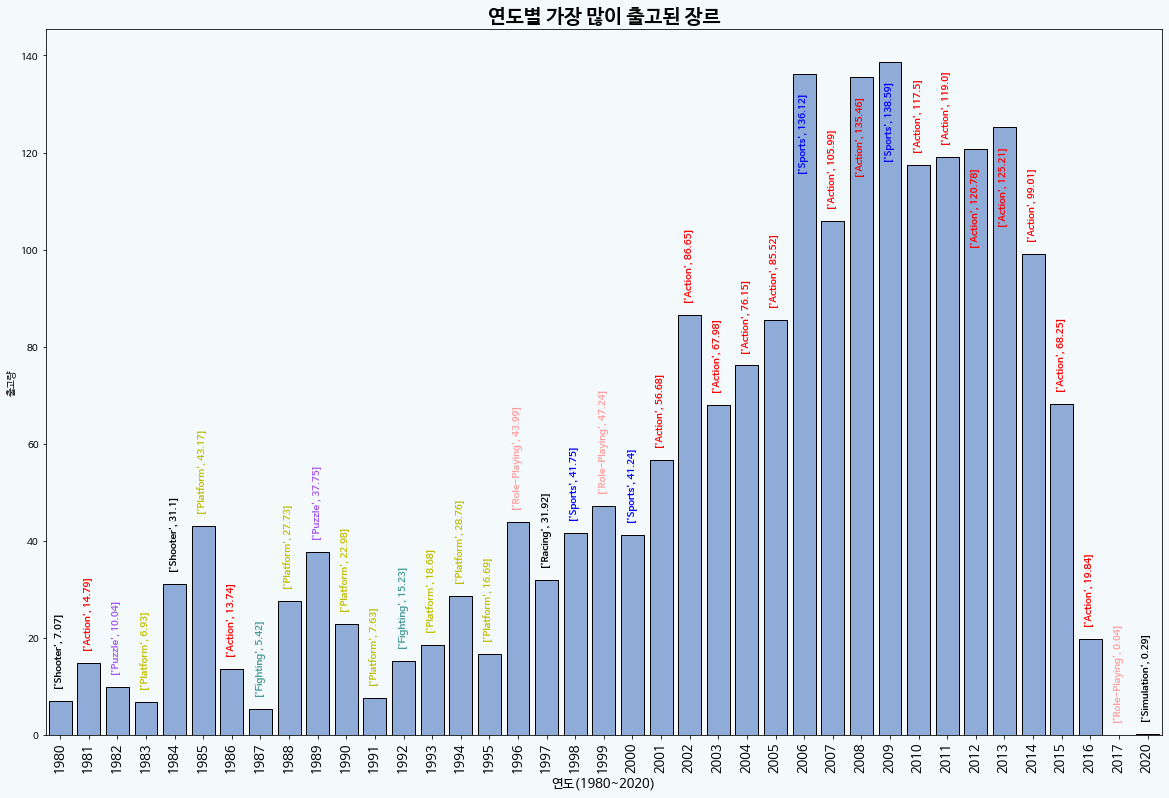

In [39]:
plt.figure(figsize=(20,13),facecolor='#F4F9FC')

pop2_df = sns.barplot(x=pop2_frame.연도,y=pop2_frame.출고량,color='#82AAE3',edgecolor='black')
pop2_df.set_xticklabels(pop2_df.get_xticklabels(), rotation=90, fontsize=13)
pop2_df.set_title('연도별 가장 많이 출고된 장르',fontsize=20,fontweight='bold')
pop2_df.set_xlabel('연도(1980~2020)',fontsize=13)
pop2_df.set_facecolor(color='#F4F9FC')


i=0
for h in pop2_df.patches:
  if h.get_height() < 120 : 
    if pop2[i][1]=='Action':
      pop2_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop2[i][1:3], ha='center',size=12, fontsize=10,color='r',rotation=90,fontweight='bold')
      i+=1
    elif pop2[i][1]=='Sports':
      pop2_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop2[i][1:3], ha='center',size=12, fontsize=10,color='b',rotation=90,fontweight='bold')
      i+=1
    elif pop2[i][1]=='Platform':
      pop2_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop2[i][1:3], ha='center',size=12, fontsize=10,color='y',rotation=90,fontweight='bold')
      i+=1
    elif pop2[i][1]=='Puzzle':
      pop2_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop2[i][1:3], ha='center',size=12, fontsize=10,color='#A555EC',rotation=90,fontweight='bold')
      i+=1
    elif pop2[i][1]=='Fighting':
      pop2_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop2[i][1:3], ha='center',size=12, fontsize=10,color='#439A97',rotation=90,fontweight='bold')
      i+=1
    elif pop2[i][1]=='Role-Playing':
      pop2_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop2[i][1:3], ha='center',size=12, fontsize=10,color='#FF9E9E',rotation=90,fontweight='bold')
      i+=1
    else:
      pop2_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop2[i][1:3], ha='center',size=12, fontsize=10,color='Black',rotation=90,fontweight='bold')
      i+=1

  else : 
    if pop2[i][1]=='Action':
      pop2_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()-20 , s=pop2[i][1:3], ha='center',size=12, fontsize=10,color='r',rotation=90,fontweight='bold')
      i+=1
    elif pop2[i][1]=='Sports':
      pop2_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()-20 , s=pop2[i][1:3], ha='center',size=12, fontsize=10,color='b',rotation=90,fontweight='bold')
      i+=1
    else:
      pop2_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()-20 , s=pop2[i][1:3], ha='center',size=12, fontsize=10,color='Black',rotation=90,fontweight='bold')
      i+=1


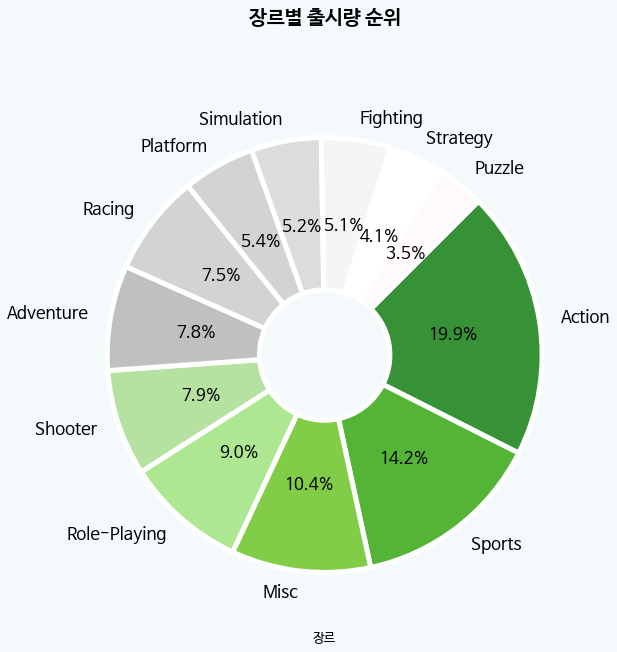

In [43]:
plt.figure(figsize=(15,10),facecolor='#F4F9FC')

def auto(pct):
  return ( '%.1f%%' % pct) if pct>=3 else ''

colors = [ '#379237','#54B435', '#82CD47','#ADE792', '#B6E2A1','silver','lightgray','lightgrey','gainsboro','whitesmoke','white','snow']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

p=df.groupby('Genre').size().sort_values(ascending=False).plot.pie(textprops={'size':17},colors=colors,wedgeprops=wedgeprops,autopct=auto,counterclock=False,startangle=45)
plt.xlabel('장르',fontsize=13)
plt.ylabel('')
plt.title('장르별 출시량 순위',fontsize=20,fontweight='bold',y=1.1)
p.set_facecolor(color='#F4F9FC')

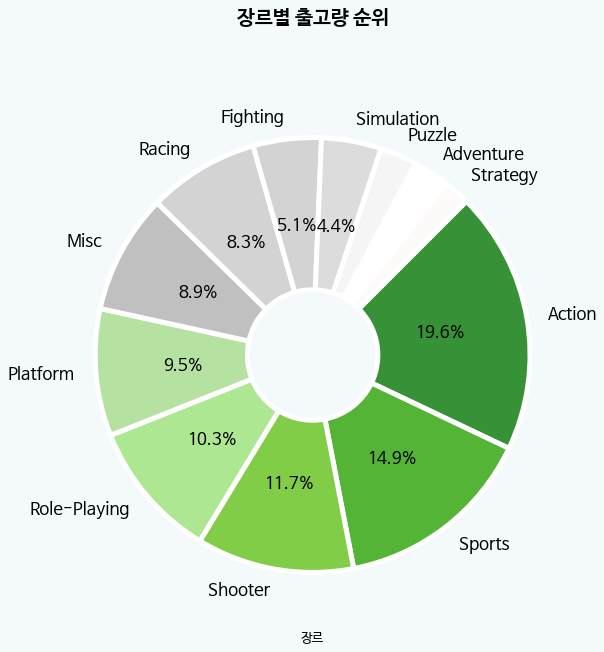

In [44]:
# 장르별 출고량순위
plt.figure(figsize=(15,10),facecolor='#F4F9FC')

def auto(pct):
  return ( '%.1f%%' % pct) if pct>=3 else ''

colors = [ '#379237','#54B435', '#82CD47','#ADE792', '#B6E2A1','silver','lightgray','lightgrey','gainsboro','whitesmoke','white','snow']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

p=df.groupby('Genre').Sales_total.sum().sort_values(ascending=False).plot.pie(textprops={'size':17},colors=colors,wedgeprops=wedgeprops,autopct=auto,counterclock=False,startangle=45)
plt.xlabel('장르',fontsize=13)
plt.ylabel('')
plt.title('장르별 출고량 순위',fontsize=20,fontweight='bold',y=1.1)
p.set_facecolor(color='#F4F9FC')

### 플랫폼

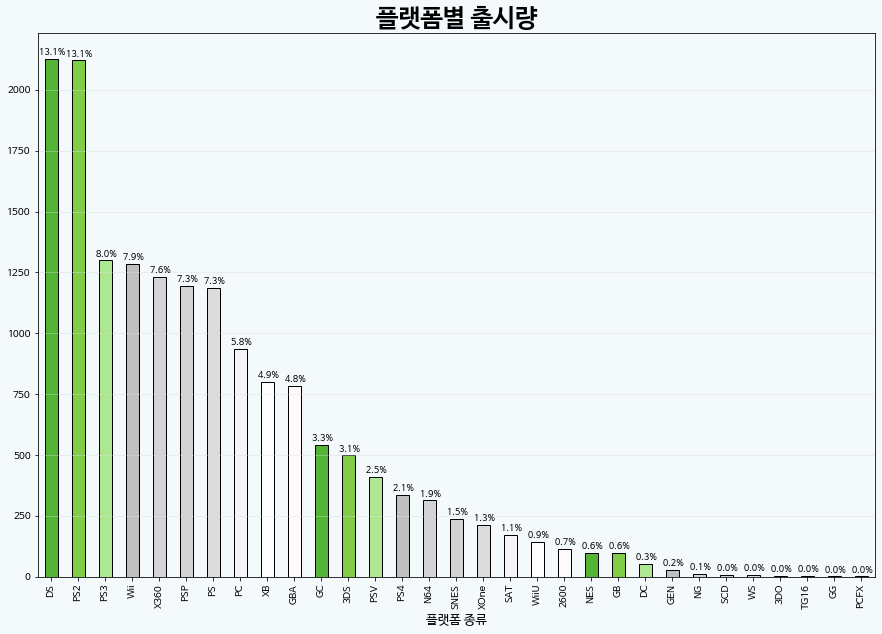

In [45]:
# 플랫폼
plt.figure(figsize=(15,10),facecolor='#F4F9FC')
# sequential_colors = sns.color_palette("RdPu")
palette=['#54B435', '#82CD47','#ADE792','silver','lightgray','lightgrey','gainsboro','whitesmoke','white','snow']

p=df.Platform.value_counts().plot(kind='bar',edgecolor='Black',color=palette)
plt.title('플랫폼별 출시량',fontsize=25,fontweight='bold')
df.Platform.value_counts(normalize=True)
p.set_facecolor(color='#F4F9FC')
p.grid(True, axis='y',color='gainsboro',alpha=0.5)
plt.xlabel('플랫폼 종류',fontsize=13)

q=df.Platform.value_counts(normalize=True)

for patch in p.patches:
  p.text(x=patch.get_x() + patch.get_width()/2 ,y=patch.get_height() + len(df)*0.001, s=f'{(patch.get_height() / len(df) )*100 : 1.1f}%', ha='center',size=9)

# DS, PS2 가 13%로 가장 많이 차지.

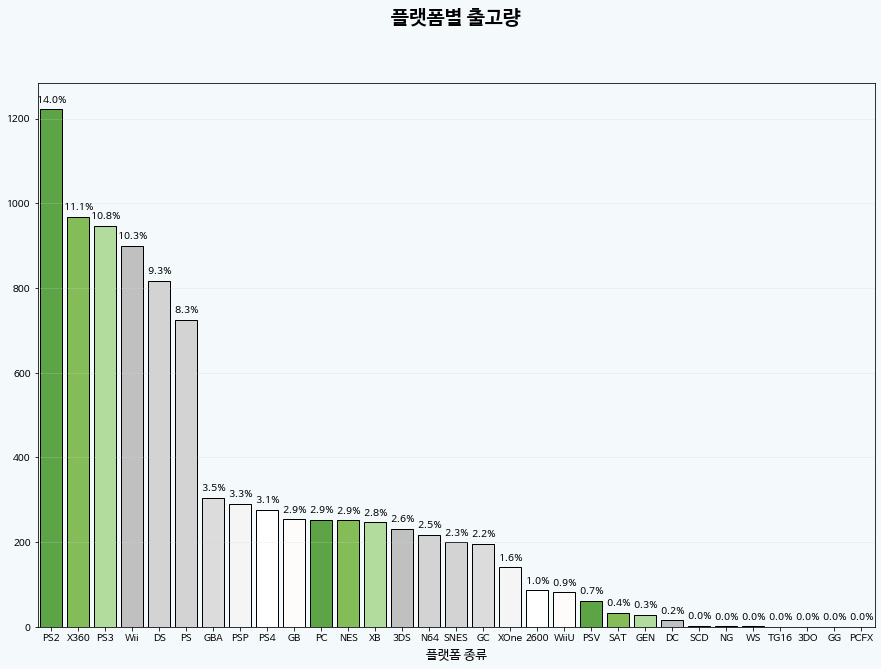

In [46]:
# 플랫폼별 출고량 순위
plt.figure(figsize=(15,10),facecolor='#F4F9FC')
a=df.groupby('Platform').Sales_total.sum().sort_values(ascending=False)
palette=['#54B435', '#82CD47','#ADE792','silver','lightgray','lightgrey','gainsboro','whitesmoke','white','snow']
h=sns.barplot(x=a.index,y=a.values,palette=palette,edgecolor='Black')
h.set_facecolor(color='#F4F9FC')
h.set_title('플랫폼별 출고량',fontsize=20,fontweight='bold',y=1.1)
h.grid(True, axis='y',color='lightgray',alpha=0.3)
plt.xlabel('플랫폼 종류',fontsize=13)

q=df.groupby('Platform').Sales_total.sum().sum()

for patch in h.patches:
  h.text(x=patch.get_x() + patch.get_width()/2 ,y=patch.get_height() + len(df)*0.001, s=f'{(patch.get_height() / q )*100 : 1.1f}%', ha='center',size=10)
  


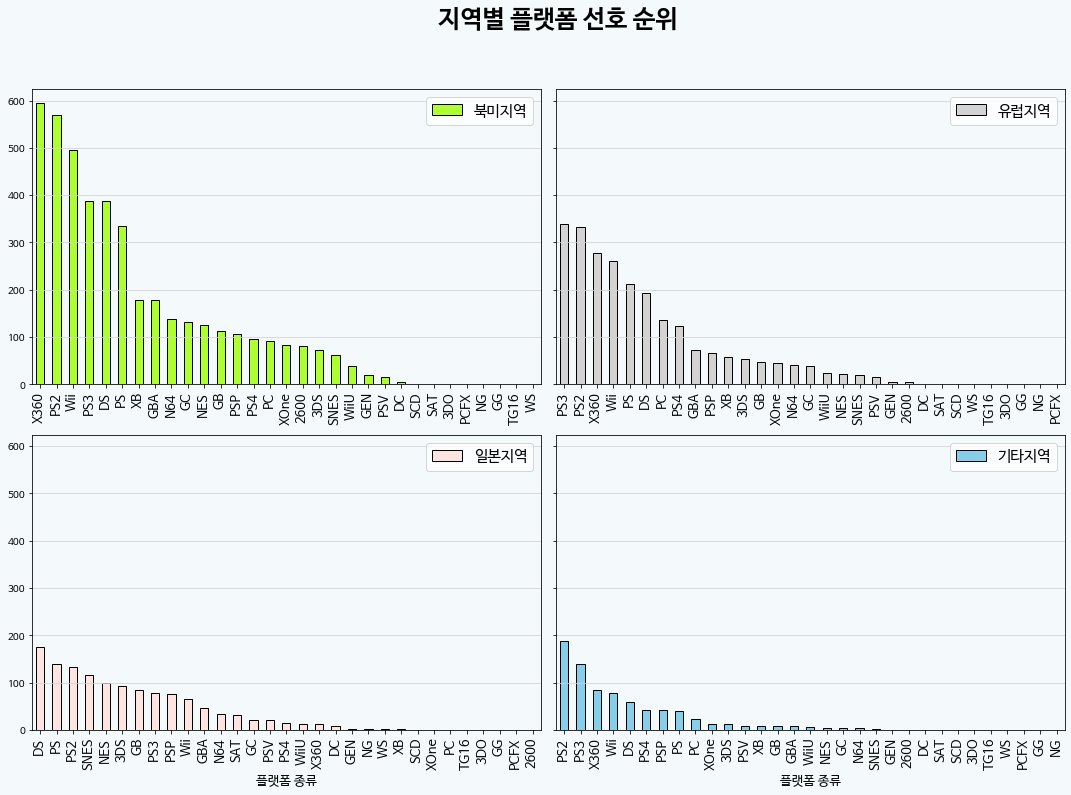

In [48]:
# 지역별로 나눠서 선호하는 플랫폼이 있는지 확인
fig, axes = plt.subplots(2, 2, figsize=(15, 10),sharey=True, facecolor='#F4F9FC')

plt.suptitle('지역별 플랫폼 선호 순위',fontsize=25,fontweight='bold',x=0.52,y=1.1)



NA = df.groupby('Platform').NA_Sales.sum().sort_values(ascending=False).plot(kind='bar',ax=axes[0,0],edgecolor='black',color='greenyellow')
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=90, fontsize=13)
# axes[0,0].set_title('북미지역',fontsize=20,fontweight='bold')
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('')
axes[0,0].set_facecolor(color='#F4F9FC')
axes[0,0].grid(True, axis='y',color='lightgray')
axes[0,0].legend(labels=['북미지역'],fontsize=15,loc='best')


EU = df.groupby('Platform').EU_Sales.sum().sort_values(ascending=False).plot(kind='bar',ax=axes[0,1],edgecolor='black',color='lightgray')
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=90, fontsize=13)
# axes[0,1].set_title('유럽지역',fontsize=20,fontweight='bold')
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')
axes[0,1].set_facecolor(color='#F4F9FC')
axes[0,1].grid(True, axis='y',color='lightgray')
axes[0,1].legend(labels=['유럽지역'],fontsize=15,loc='best')


JP = df.groupby('Platform').JP_Sales.sum().sort_values(ascending=False).plot(kind='bar',ax=axes[1,0],edgecolor='black',color='mistyrose')
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=90, fontsize=13)
# axes[1,0].set_title('일본지역',fontsize=20,fontweight='bold')
axes[1,0].set_xlabel('플랫폼 종류',fontsize=13)
axes[1,0].set_ylabel('')
axes[1,0].set_facecolor(color='#F4F9FC')
axes[1,0].grid(True, axis='y',color='lightgray')
axes[1,0].legend(labels=['일본지역'],fontsize=15,loc='best')



OTH = df.groupby('Platform').Other_Sales.sum().sort_values(ascending=False).plot(kind='bar',ax=axes[1,1],edgecolor='black',color='skyblue')
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=90, fontsize=13)
# axes[1,1].set_title('기타지역',fontsize=20,fontweight='bold')
axes[1,1].set_xlabel('플랫폼 종류',fontsize=13)
axes[1,1].set_ylabel('')
axes[1,1].set_facecolor(color='#F4F9FC')
axes[1,1].grid(True, axis='y',color='lightgray')
axes[1,1].legend(labels=['기타지역'],fontsize=15,loc='best')


plt.tight_layout()

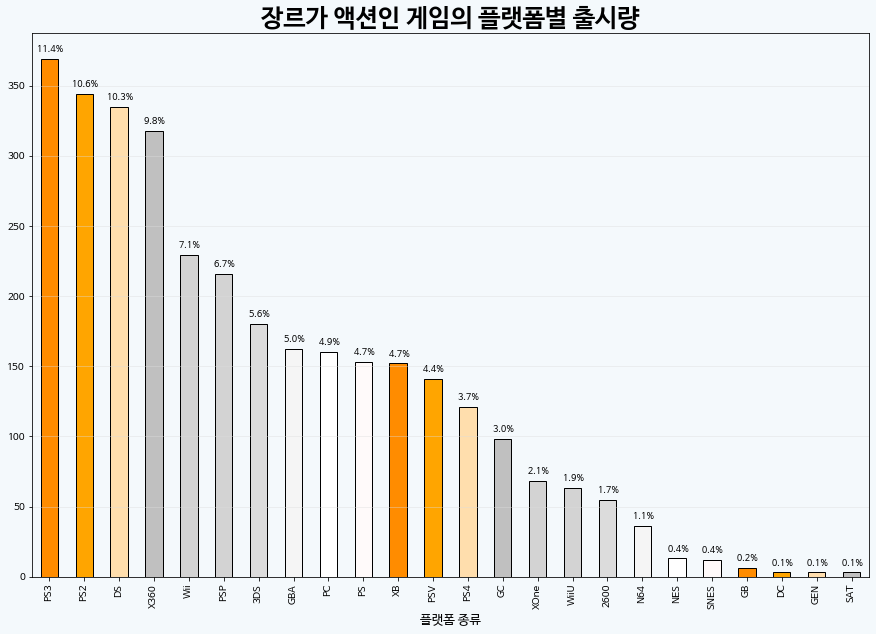

In [50]:
# 플랫폼
plt.figure(figsize=(15,10),facecolor='#F4F9FC')
# sequential_colors = sns.color_palette("RdPu")
palette=['darkorange', 'orange','navajowhite','silver','lightgray','lightgrey','gainsboro','whitesmoke','white','snow']

p=df.query('Genre=="Action"').Platform.value_counts().plot(kind='bar',edgecolor='Black',color=palette)
plt.title('장르가 액션인 게임의 플랫폼별 출시량',fontsize=25,fontweight='bold')
df.Platform.value_counts(normalize=True)
p.set_facecolor(color='#F4F9FC')
p.grid(True, axis='y',color='gainsboro',alpha=0.5)
plt.xlabel('플랫폼 종류',fontsize=13)

q=df.query('Genre=="Action"')

for patch in p.patches:
  p.text(x=patch.get_x() + patch.get_width()/2 ,y=patch.get_height()+5, s=f'{(patch.get_height() / len(q) )*100 : 1.1f}%', ha='center',size=9)

# DS, PS2 가 13%로 가장 많이 차지.

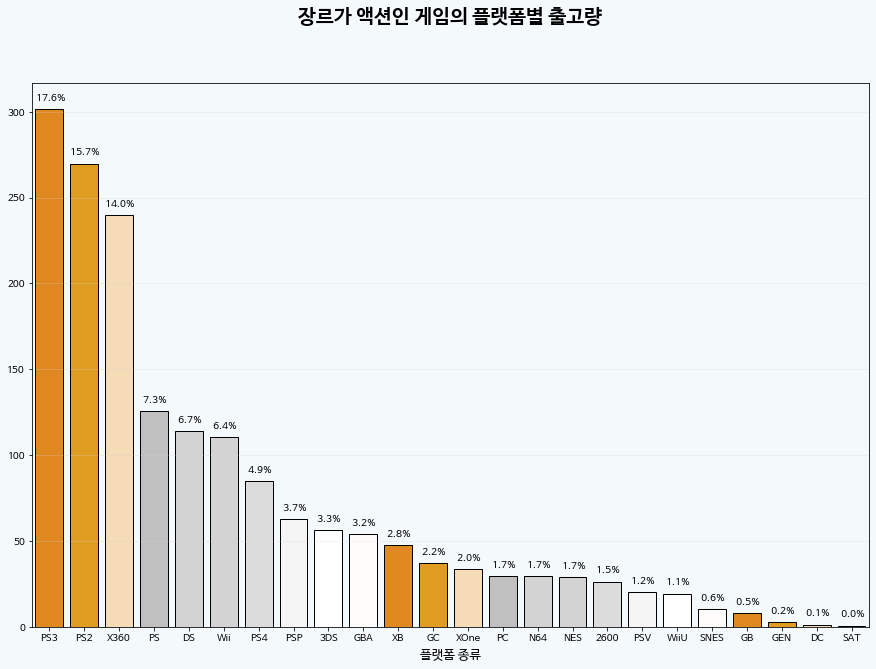

In [49]:
# 플랫폼별 출고량 순위
plt.figure(figsize=(15,10),facecolor='#F4F9FC')
a=df.query('Genre=="Action"').groupby('Platform').Sales_total.sum().sort_values(ascending=False)
palette=['darkorange', 'orange','navajowhite','silver','lightgray','lightgrey','gainsboro','whitesmoke','white','snow']
h=sns.barplot(x=a.index,y=a.values,palette=palette,edgecolor='Black')
h.set_facecolor(color='#F4F9FC')
h.set_title('장르가 액션인 게임의 플랫폼별 출고량',fontsize=20,fontweight='bold',y=1.1)
h.grid(True, axis='y',color='lightgray',alpha=0.3)
plt.xlabel('플랫폼 종류',fontsize=13)

q=df.query('Genre=="Action"').groupby('Platform').Sales_total.sum().sum()

for patch in h.patches:
  h.text(x=patch.get_x() + patch.get_width()/2 ,y=patch.get_height()+5, s=f'{(patch.get_height() / q )*100 : 1.1f}%', ha='center',size=10)
  


In [ ]:
df.query('Genre=="Action"').Platform.value_counts()

PS3     369
PS2     344
DS      335
X360    318
Wii     229
PSP     216
3DS     180
GBA     162
PC      160
PS      153
XB      152
PSV     141
PS4     121
GC       98
XOne     68
WiiU     63
2600     55
N64      36
NES      13
SNES     12
GB        6
DC        3
GEN       3
SAT       3
Name: Platform, dtype: int64

In [ ]:
df.query('Genre!="Action"').Platform.value_counts()

DS      1792
PS2     1777
Wii     1055
PS      1032
PSP      977
PS3      930
X360     913
PC       775
XB       647
GBA      622
GC       443
3DS      318
N64      277
PSV      268
SNES     227
PS4      214
SAT      170
XOne     144
GB        91
NES       85
WiiU      80
2600      60
DC        49
GEN       24
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: Platform, dtype: int64

In [51]:
y = df.groupby('Year').size().index
y

pop4 = []

for i in y:
  pop4.append([i,df[df.Year==i]['Platform'].value_counts().index[0],df[df.Year==i]['Platform'].value_counts()[0]])

pop4

[[1980, '2600', 8],
 [1981, '2600', 46],
 [1982, '2600', 36],
 [1983, '2600', 11],
 [1984, 'NES', 13],
 [1985, 'NES', 11],
 [1986, 'NES', 19],
 [1987, 'NES', 10],
 [1988, 'NES', 11],
 [1989, 'GB', 10],
 [1990, 'NES', 8],
 [1991, 'SNES', 24],
 [1992, 'SNES', 21],
 [1993, 'SNES', 46],
 [1994, 'SNES', 53],
 [1995, 'PS', 99],
 [1996, 'PS', 163],
 [1997, 'PS', 188],
 [1998, 'PS', 248],
 [1999, 'PS', 198],
 [2000, 'PS', 159],
 [2001, 'PS2', 184],
 [2002, 'PS2', 280],
 [2003, 'PS2', 256],
 [2004, 'PS2', 258],
 [2005, 'PS2', 260],
 [2006, 'PS2', 258],
 [2007, 'DS', 377],
 [2008, 'DS', 490],
 [2009, 'DS', 405],
 [2010, 'DS', 326],
 [2011, 'PS3', 216],
 [2012, 'PS3', 147],
 [2013, 'PS3', 127],
 [2014, 'PS3', 108],
 [2015, 'PS4', 136],
 [2016, 'PS4', 107],
 [2017, 'PSV', 2],
 [2020, 'DS', 1]]

In [52]:
pop4_frame = pd.DataFrame(pop4)
pop4_frame.columns=['연도','플랫폼','출시량']

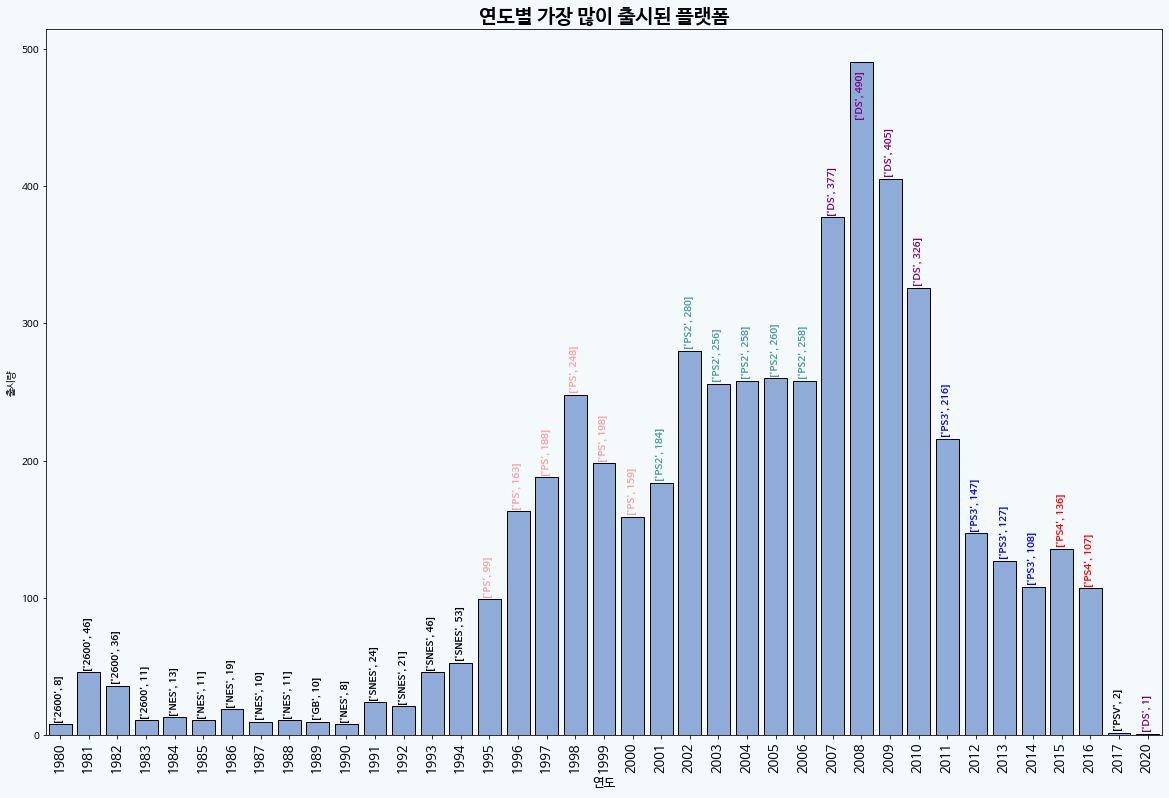

In [53]:
plt.figure(figsize=(20,13),facecolor='#F4F9FC')

pop4_df = sns.barplot(x=pop4_frame.연도,y=pop4_frame.출시량,color='#82AAE3',edgecolor='black')
pop4_df.set_xticklabels(pop4_df.get_xticklabels(), rotation=90, fontsize=13)
pop4_df.set_title('연도별 가장 많이 출시된 플랫폼',fontsize=20,fontweight='bold')
pop4_df.set_xlabel('연도',fontsize=13)
pop4_df.set_facecolor(color='#F4F9FC')

i=0
for h in pop4_df.patches:
  if h.get_height() < 450 : 
    if pop4[i][1]=='PS4':
      pop4_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop4[i][1:3], ha='center',size=12, fontsize=10,color='r',rotation=90,fontweight='bold')
      i+=1
    elif pop4[i][1]=='PS3':
      pop4_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop4[i][1:3], ha='center',size=12, fontsize=10,color='b',rotation=90,fontweight='bold')
      i+=1
    elif pop4[i][1]=='X360':
      pop4_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop4[i][1:3], ha='center',size=12, fontsize=10,color='y',rotation=90,fontweight='bold')
      i+=1
    elif pop4[i][1]=='Wii':
      pop4_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop4[i][1:3], ha='center',size=12, fontsize=10,color='#A555EC',rotation=90,fontweight='bold')
      i+=1
    elif pop4[i][1]=='PS2':
      pop4_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop4[i][1:3], ha='center',size=12, fontsize=10,color='#439A97',rotation=90,fontweight='bold')
      i+=1
    elif pop4[i][1]=='PS':
      pop4_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop4[i][1:3], ha='center',size=12, fontsize=10,color='#FF9E9E',rotation=90,fontweight='bold')
      i+=1
    elif pop4[i][1]=='DS':
      pop4_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop4[i][1:3], ha='center',size=12, fontsize=10,color='purple',rotation=90,fontweight='bold')
      i+=1
    else:
      pop4_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop4[i][1:3], ha='center',size=12, fontsize=10,color='Black',rotation=90,fontweight='bold')
      i+=1

  else : 
    if pop4[i][1]=='DS':
      pop4_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()-40 , s=pop4[i][1:3], ha='center',size=12, fontsize=10,color='purple',rotation=90,fontweight='bold')
      i+=1
    

In [54]:
y = df.groupby('Year').size().index
y

pop3 = []

for i in y:
  w = df[df.Year==i][['Platform','Sales_total']].groupby('Platform').sum().sort_values(by='Sales_total')
  pop3.append([i,w.index[-1],round(float(w.values[-1]),2)])

In [55]:
pop3_frame = pd.DataFrame(pop3)
pop3_frame.columns=['연도','플랫폼','출고량']
pop3_frame

,연도,플랫폼,출고량
0,1980,2600,10.88
1,1981,2600,35.68
2,1982,2600,28.88
3,1983,NES,10.96
4,1984,NES,50.08
5,1985,NES,53.44
6,1986,NES,36.41
7,1987,NES,19.76
8,1988,NES,45.01
9,1989,GB,64.97


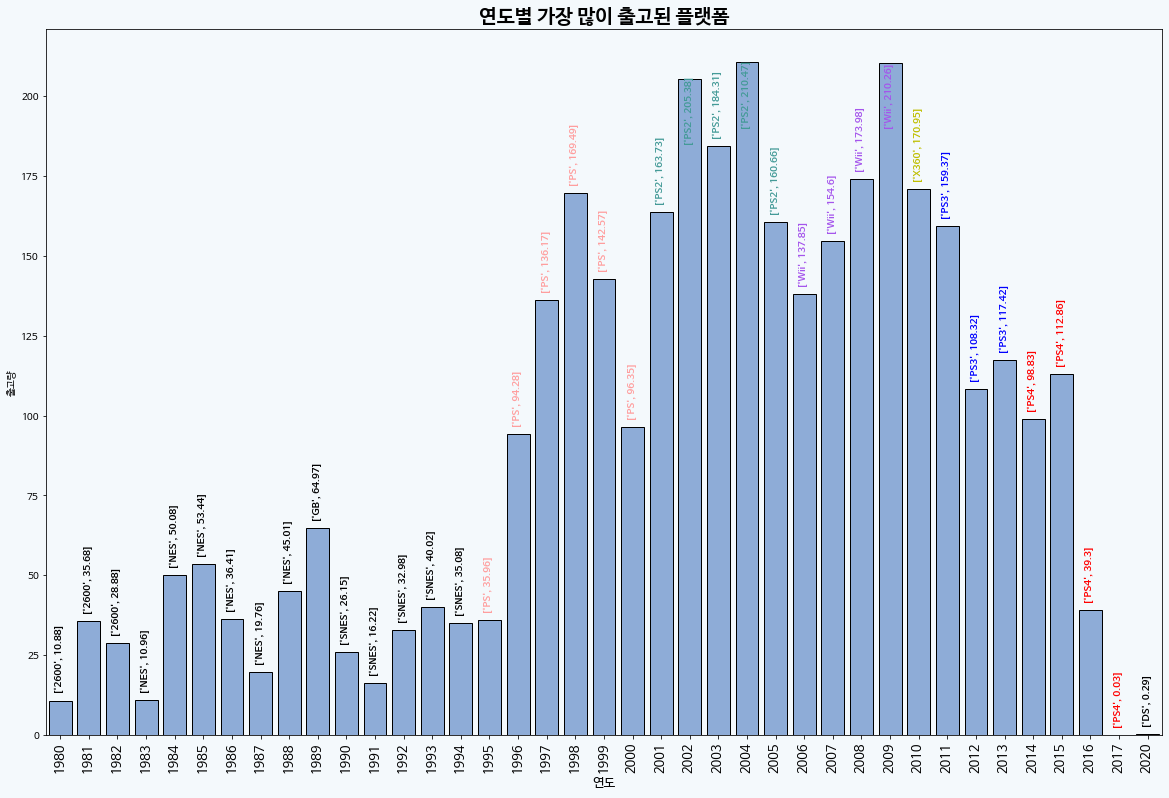

In [56]:
plt.figure(figsize=(20,13),facecolor='#F4F9FC')

pop3_df = sns.barplot(x=pop3_frame.연도,y=pop3_frame.출고량,color='#82AAE3',edgecolor='black')
pop3_df.set_xticklabels(pop3_df.get_xticklabels(), rotation=90, fontsize=13)
pop3_df.set_title('연도별 가장 많이 출고된 플랫폼',fontsize=20,fontweight='bold')
pop3_df.set_xlabel('연도',fontsize=13)
pop3_df.set_facecolor(color='#F4F9FC')

i=0
for h in pop3_df.patches:
  if h.get_height() < 200 : 
    if pop3[i][1]=='PS4':
      pop3_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop3[i][1:3], ha='center',size=12, fontsize=10,color='r',rotation=90,fontweight='bold')
      i+=1
    elif pop3[i][1]=='PS3':
      pop3_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop3[i][1:3], ha='center',size=12, fontsize=10,color='b',rotation=90,fontweight='bold')
      i+=1
    elif pop3[i][1]=='X360':
      pop3_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop3[i][1:3], ha='center',size=12, fontsize=10,color='y',rotation=90,fontweight='bold')
      i+=1
    elif pop3[i][1]=='Wii':
      pop3_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop3[i][1:3], ha='center',size=12, fontsize=10,color='#A555EC',rotation=90,fontweight='bold')
      i+=1
    elif pop3[i][1]=='PS2':
      pop3_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop3[i][1:3], ha='center',size=12, fontsize=10,color='#439A97',rotation=90,fontweight='bold')
      i+=1
    elif pop3[i][1]=='PS':
      pop3_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop3[i][1:3], ha='center',size=12, fontsize=10,color='#FF9E9E',rotation=90,fontweight='bold')
      i+=1
    else:
      pop3_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop3[i][1:3], ha='center',size=12, fontsize=10,color='Black',rotation=90,fontweight='bold')
      i+=1

  else : 
    if pop3[i][1]=='PS4':
      pop3_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()-20 , s=pop3[i][1:3], ha='center',size=12, fontsize=10,color='r',rotation=90,fontweight='bold')
      i+=1
    elif pop3[i][1]=='PS3':
      pop3_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()-20 , s=pop3[i][1:3], ha='center',size=12, fontsize=10,color='b',rotation=90,fontweight='bold')
      i+=1
    elif pop3[i][1]=='PS2':
      pop3_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()-20 , s=pop3[i][1:3], ha='center',size=12, fontsize=10,color='#439A97',rotation=90,fontweight='bold')
      i+=1
    elif pop3[i][1]=='Wii':
      pop3_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()-20 , s=pop3[i][1:3], ha='center',size=12, fontsize=10,color='#A555EC',rotation=90,fontweight='bold')
      i+=1
    else:
      pop3_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()-20 , s=pop3[i][1:3], ha='center',size=12, fontsize=10,color='Black',rotation=90,fontweight='bold')
      i+=1

### 출고지역

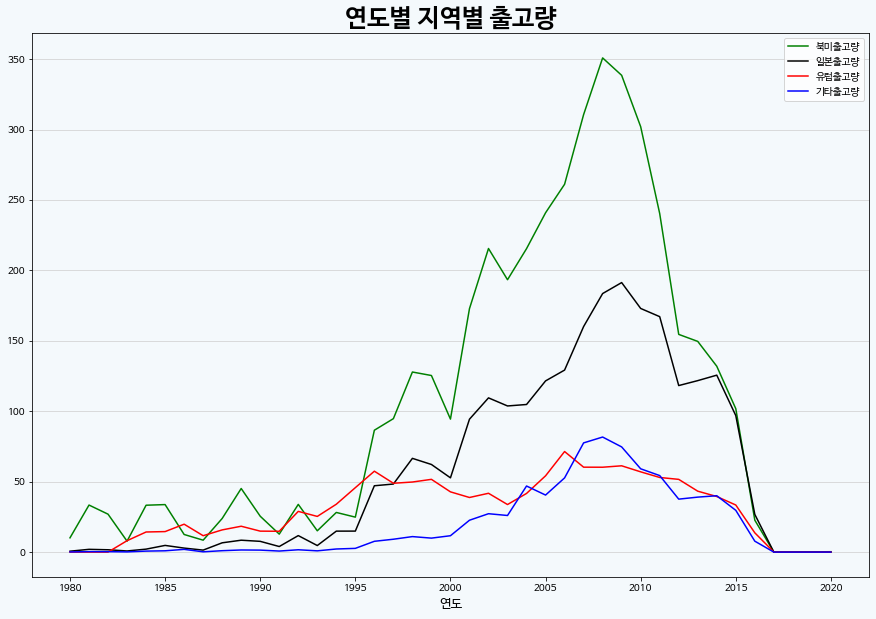

In [57]:
plt.figure(figsize=(15,10),facecolor='#F4F9FC')
p=df.groupby('Year').NA_Sales.sum().plot(kind='line',color='green',label='북미출고량')
df.groupby('Year').EU_Sales.sum().plot(kind='line',color='Black',label='일본출고량')
df.groupby('Year').JP_Sales.sum().plot(kind='line',color='r',label='유럽출고량')
df.groupby('Year').Other_Sales.sum().plot(kind='line',color='blue',label='기타출고량')
plt.title('연도별 지역별 출고량',fontsize=25,fontweight='bold')
plt.grid(True, axis='y',color='lightgray')
p.set_facecolor(color='#F4F9FC')
plt.xlabel('연도',fontsize=13)
plt.legend()

Text(0.5, 0, '지역')

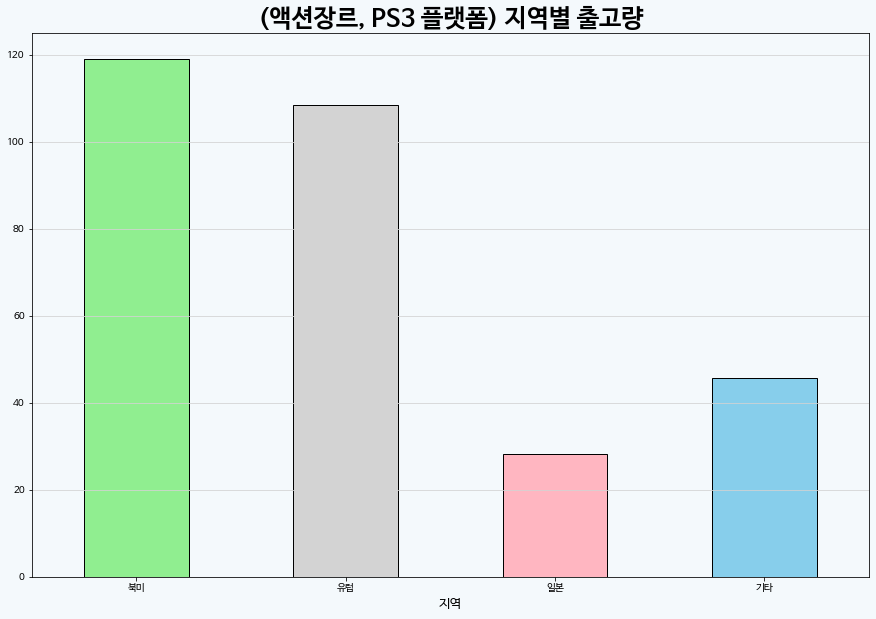

In [60]:
# 장르 액션, 플랫폼 ps3 설정후 지역별 출고량 파악
new=df.query('Genre=="Action" & Platform=="PS3"')
a=new.groupby('Year').NA_Sales.sum()
b=new.groupby('Year').EU_Sales.sum()
c=new.groupby('Year').JP_Sales.sum()
d=new.groupby('Year').Other_Sales.sum()
all=pd.DataFrame({'북미':a,'유럽':b,'일본':c,'기타':d})

plt.figure(figsize=(15,10),facecolor='#F4F9FC')
p=all.sum().plot(kind='bar',rot=0, color=['lightgreen','lightgray','lightpink','skyblue'],edgecolor='Black')
plt.title('(액션장르, PS3 플랫폼) 지역별 출고량',fontsize=25,fontweight='bold')
plt.grid(True, axis='y',color='lightgray')
p.set_facecolor(color='#F4F9FC')
plt.xlabel('지역',fontsize=13)


### 회사

Electronic Arts                 0.082015
Activision                      0.059294
Namco Bandai Games              0.056893
Ubisoft                         0.056216
Konami Digital Entertainment    0.050551
                                  ...   
Marvelous Games                 0.000062
Panther Software                0.000062
Playmore                        0.000062
mixi, Inc                       0.000062
Mystique                        0.000062
Name: Publisher, Length: 575, dtype: float64

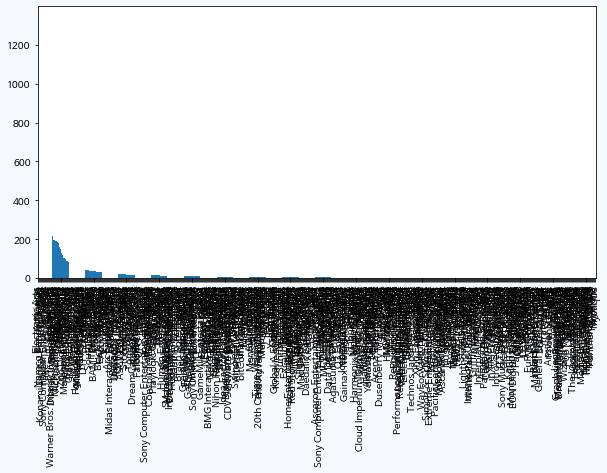

In [ ]:
# 게임 배급회사
plt.figure(figsize=(10,5),facecolor='#F4F9FC')
df.Publisher.value_counts().plot(kind='bar')
df.Publisher.value_counts(normalize=True)

# 모든 회사를 시각화로 보는건 어려워보이니 상위 10위까지만 보도록 한다.

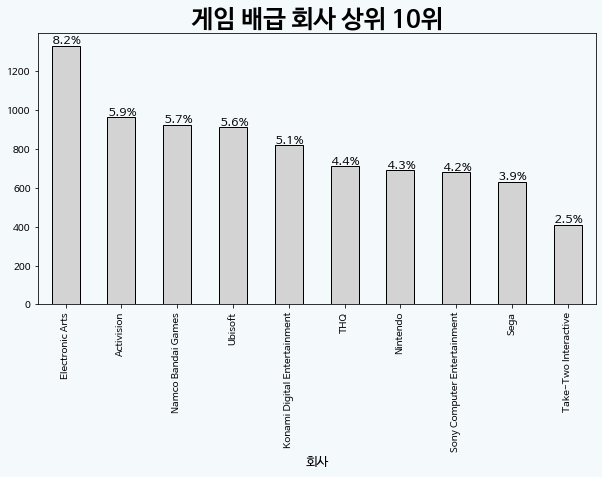

In [63]:
# Publisher
df_p=df.Publisher.value_counts()[0:10]
plt.figure(figsize=(10,5),facecolor='#F4F9FC')
P=df_p.plot(kind='bar',rot=90,color='lightgray', edgecolor='black')
plt.title('게임 배급 회사 상위 10위',fontsize=25,fontweight='bold')
P.set_facecolor(color='#F4F9FC')
plt.xlabel('회사',fontsize=13)

for patch in P.patches:
  P.text(x=patch.get_x() + patch.get_width()/2 ,y=patch.get_height() + len(df_p), s=f'{(patch.get_height()/len(df))*100 : 1.1f}%', ha='center',size=12)

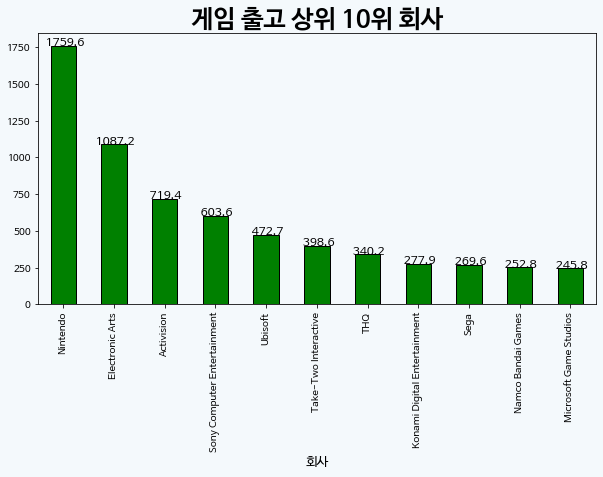

In [62]:
#회사별 출고량 순위
plt.figure(figsize=(10,5),facecolor='#F4F9FC')
ps=df.groupby('Publisher')['Sales_total'].sum().sort_values(ascending=False)[0:11].plot(kind='bar',color='green',edgecolor='black')
plt.title('게임 출고 상위 10위 회사',fontsize=25,fontweight='bold')
ps.set_facecolor(color='#F4F9FC')
ps.set_xlabel('회사',fontsize=13)


for patch in ps.patches:
  ps.text(x=patch.get_x() + patch.get_width()/2 ,y=patch.get_height()+0.05, s=f'{patch.get_height(): 1.1f}', ha='center',size=12)

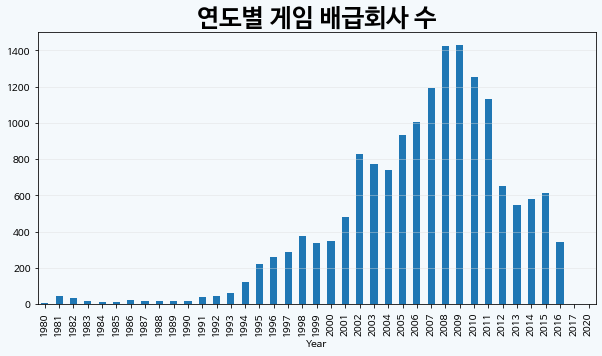

In [ ]:
# 연도별 게임 배급회사 수
plt.figure(figsize=(10,5),facecolor='#F4F9FC')
p=df[['Publisher','Year']].groupby('Year').size().plot(kind='bar')
plt.title('연도별 게임 배급회사 수',fontsize=25,fontweight='bold')
p.set_facecolor(color='#F4F9FC')
p.grid(True, axis='y',color='gainsboro',alpha=0.5)

In [64]:
y = df.groupby('Year').size().index
y

pop5 = []

for i in y:
  w = df[df.Year==i][['Publisher','Sales_total']].groupby('Publisher').sum().sort_values(by='Sales_total')
  pop5.append([i,w.index[-1],round(float(w.values[-1]),2)])


In [65]:
# 연도별 출고량많은 회사
pop5_frame = pd.DataFrame(pop5)
pop5_frame.columns = ['연도','출고회사','출고량']
pop5_frame

,연도,출고회사,출고량
0,1980,Atari,8.35
1,1981,Activision,8.49
2,1982,Atari,19.43
3,1983,Nintendo,10.96
4,1984,Nintendo,45.55
5,1985,Nintendo,49.95
6,1986,Nintendo,16.17
7,1987,Nintendo,11.95
8,1988,Nintendo,36.44
9,1989,Nintendo,63.87


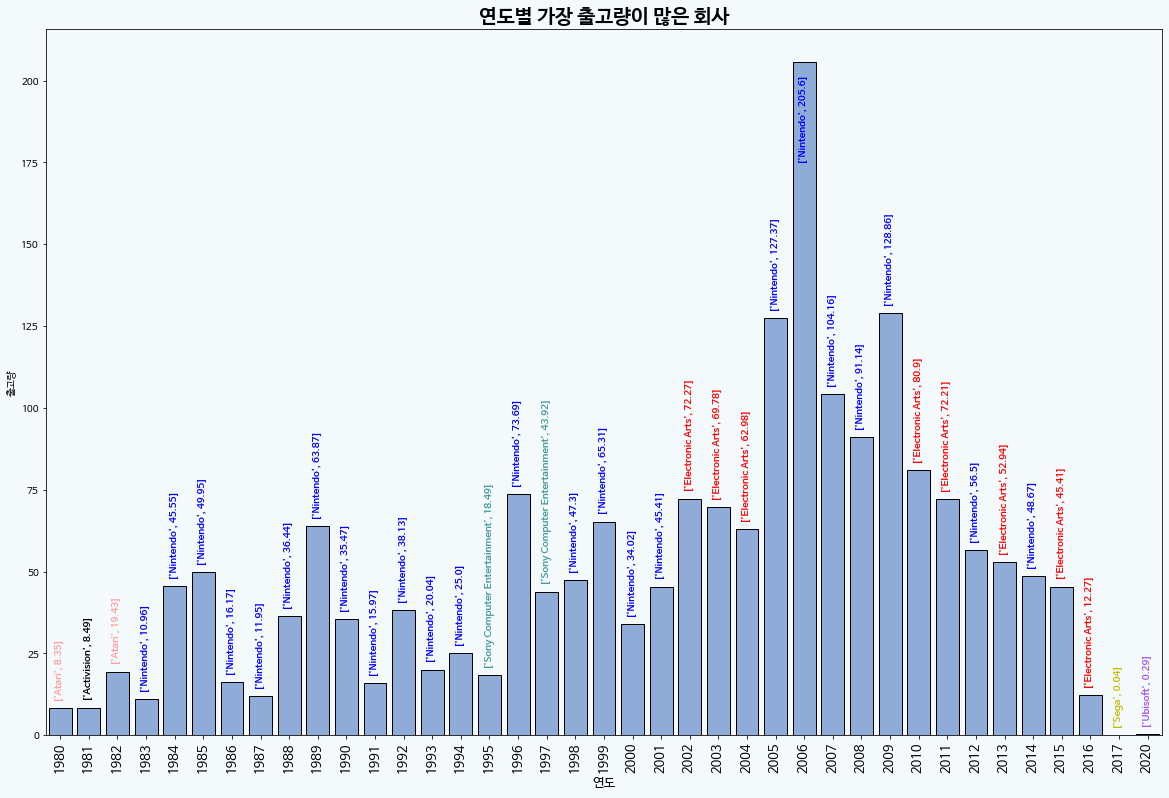

In [66]:
plt.figure(figsize=(20,13),facecolor='#F4F9FC')

pop5_df = sns.barplot(x=pop5_frame.연도,y=pop5_frame.출고량,color='#82AAE3',edgecolor='black')
pop5_df.set_xticklabels(pop5_df.get_xticklabels(), rotation=90, fontsize=13)
pop5_df.set_title('연도별 가장 출고량이 많은 회사',fontsize=20,fontweight='bold')
pop5_df.set_xlabel('연도',fontsize=13)
pop5_df.set_facecolor(color='#F4F9FC')


i=0
for h in pop5_df.patches:
  if h.get_height() < 175 : 
    if pop5[i][1]=='Electronic Arts':
      pop5_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop5[i][1:3], ha='center',size=12, fontsize=10,color='r',rotation=90,fontweight='bold')
      i+=1
    elif pop5[i][1]=='Nintendo':
      pop5_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop5[i][1:3], ha='center',size=12, fontsize=10,color='b',rotation=90,fontweight='bold')
      i+=1
    elif pop5[i][1]=='Sega':
      pop5_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop5[i][1:3], ha='center',size=12, fontsize=10,color='y',rotation=90,fontweight='bold')
      i+=1
    elif pop5[i][1]=='Ubisoft':
      pop5_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop5[i][1:3], ha='center',size=12, fontsize=10,color='#A555EC',rotation=90,fontweight='bold')
      i+=1
    elif pop5[i][1]=='Sony Computer Entertainment':
      pop5_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop5[i][1:3], ha='center',size=12, fontsize=10,color='#439A97',rotation=90,fontweight='bold')
      i+=1
    elif pop5[i][1]=='Atari':
      pop5_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop5[i][1:3], ha='center',size=12, fontsize=10,color='#FF9E9E',rotation=90,fontweight='bold')
      i+=1
    else:
      pop5_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop5[i][1:3], ha='center',size=12, fontsize=10,color='Black',rotation=90,fontweight='bold')
      i+=1

  else : 
    if pop5[i][1]=='Nintendo':
      pop5_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()-30 , s=pop5[i][1:3], ha='center',size=12, fontsize=10,color='b',rotation=90,fontweight='bold')
      i+=1


In [67]:
# 연도별 배급이 많은 회사
y = df.groupby('Year').size().index
y

pop6 = []

for i in y:
  w = df[df.Year==i].groupby('Publisher').size().sort_values()
  pop6.append([i,w.index[-1],round(float(w.values[-1]),2)])


In [68]:
# 연도별 출고량많은 회사
pop6_frame = pd.DataFrame(pop6)
pop6_frame.columns = ['연도','배급회사','배급량']
pop6_frame

,연도,배급회사,배급량
0,1980,Atari,4.0
1,1981,Atari,11.0
2,1982,Atari,14.0
3,1983,Nintendo,6.0
4,1984,Nintendo,9.0
5,1985,Nintendo,7.0
6,1986,Nintendo,6.0
7,1987,Nintendo,4.0
8,1988,Nintendo,6.0
9,1989,Nintendo,9.0


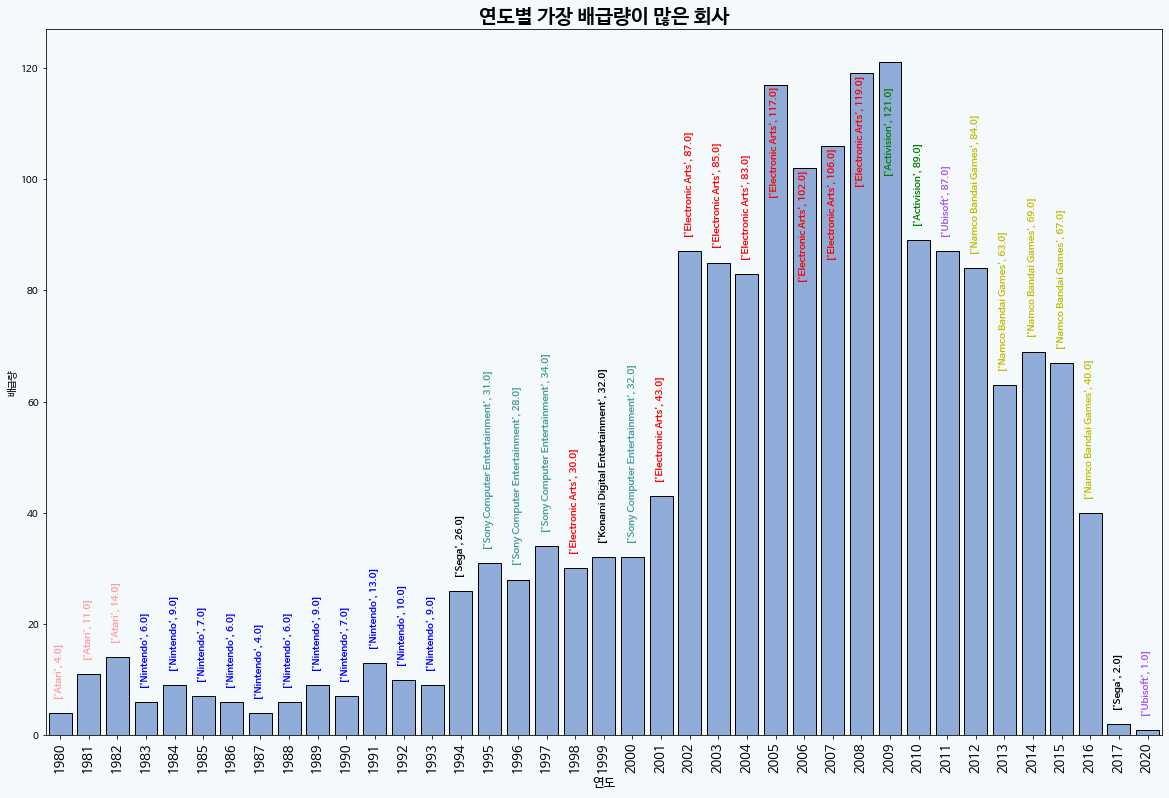

In [70]:
plt.figure(figsize=(20,13),facecolor='#F4F9FC')

pop6_df = sns.barplot(x=pop6_frame.연도,y=pop6_frame.배급량,color='#82AAE3',edgecolor='black')
pop6_df.set_xticklabels(pop6_df.get_xticklabels(), rotation=90, fontsize=13)
pop6_df.set_title('연도별 가장 배급량이 많은 회사',fontsize=20,fontweight='bold')
pop6_df.set_xlabel('연도',fontsize=13)
pop6_df.set_facecolor(color='#F4F9FC')


i=0
for h in pop6_df.patches:
  if h.get_height() < 100 : 
    if pop6[i][1]=='Electronic Arts':
      pop6_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop6[i][1:3], ha='center',size=12, fontsize=10,color='r',rotation=90,fontweight='bold')
      i+=1
    elif pop6[i][1]=='Nintendo':
      pop6_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop6[i][1:3], ha='center',size=12, fontsize=10,color='b',rotation=90,fontweight='bold')
      i+=1
    elif pop6[i][1]=='Namco Bandai Games':
      pop6_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop6[i][1:3], ha='center',size=12, fontsize=10,color='y',rotation=90,fontweight='bold')
      i+=1
    elif pop6[i][1]=='Ubisoft':
      pop6_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop6[i][1:3], ha='center',size=12, fontsize=10,color='#A555EC',rotation=90,fontweight='bold')
      i+=1
    elif pop6[i][1]=='Sony Computer Entertainment':
      pop6_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop6[i][1:3], ha='center',size=12, fontsize=10,color='#439A97',rotation=90,fontweight='bold')
      i+=1
    elif pop6[i][1]=='Atari':
      pop6_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop6[i][1:3], ha='center',size=12, fontsize=10,color='#FF9E9E',rotation=90,fontweight='bold')
      i+=1
    elif pop6[i][1]=='Activision':
      pop6_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop6[i][1:3], ha='center',size=12, fontsize=10,color='green',rotation=90,fontweight='bold')
      i+=1
    else:
      pop6_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()+3 , s=pop6[i][1:3], ha='center',size=12, fontsize=10,color='Black',rotation=90,fontweight='bold')
      i+=1
    

  else : 
    if pop6[i][1]=='Electronic Arts':
      pop6_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()-20 , s=pop6[i][1:3], ha='center',size=12, fontsize=10,color='r',rotation=90,fontweight='bold')
      i+=1
    elif pop6[i][1]=='Nintendo':
      pop6_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()-20 , s=pop6[i][1:3], ha='center',size=12, fontsize=10,color='b',rotation=90,fontweight='bold')
      i+=1
    elif pop6[i][1]=='Namco Bandai Games':
      pop6_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()-20 , s=pop6[i][1:3], ha='center',size=12, fontsize=10,color='y',rotation=90,fontweight='bold')
      i+=1
    elif pop6[i][1]=='Ubisoft':
      pop6_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()-20 , s=pop6[i][1:3], ha='center',size=12, fontsize=10,color='#A555EC',rotation=90,fontweight='bold')
      i+=1
    elif pop6[i][1]=='Sony Computer Entertainment':
      pop6_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()-20 , s=pop6[i][1:3], ha='center',size=12, fontsize=10,color='#439A97',rotation=90,fontweight='bold')
      i+=1
    elif pop6[i][1]=='Atari':
      pop6_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()-20 , s=pop6[i][1:3], ha='center',size=12, fontsize=10,color='#FF9E9E',rotation=90,fontweight='bold')
      i+=1
    elif pop6[i][1]=='Activision':
      pop6_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()-20 , s=pop6[i][1:3], ha='center',size=12, fontsize=10,color='green',rotation=90,fontweight='bold')
      i+=1
    else:
      pop6_df.text(x=h.get_x() + h.get_width()/2 ,y=h.get_height()-20 , s=pop6[i][1:3], ha='center',size=12, fontsize=10,color='Black',rotation=90,fontweight='bold')
      i+=1


Text(0, 0.5, '회사')

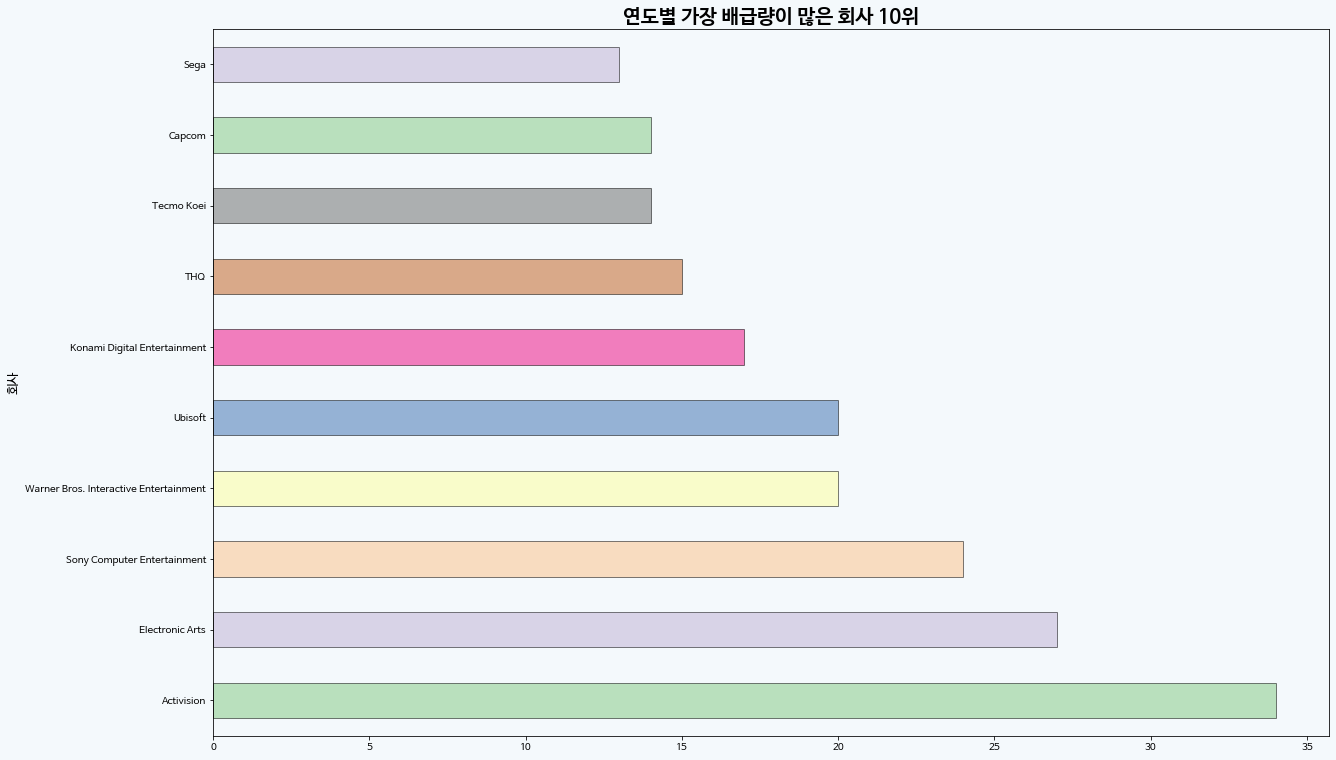

In [72]:
# 장르액션, 플랫폼 PS2, 출고지역 북미로 설정하여 어느 회사에서 배급, 출고해야 가장 좋은지 알아본다.
plt.figure(figsize=(20,13),facecolor='#F4F9FC')
new2=df.query('Genre=="Action" & Platform=="PS3" & NA_Sales!=0')
colors2 = sns.color_palette('Accent',len(new2))
q=new2.groupby('Publisher').size().sort_values(ascending=False)[0:10].plot(kind='barh',color=colors2,edgecolor='Black',alpha=0.5)
q.set_title('연도별 가장 배급량이 많은 회사 10위',fontsize=20,fontweight='bold')
q.set_facecolor(color='#F4F9FC')
q.set_ylabel('회사',fontsize=13)

Text(0, 0.5, '회사')

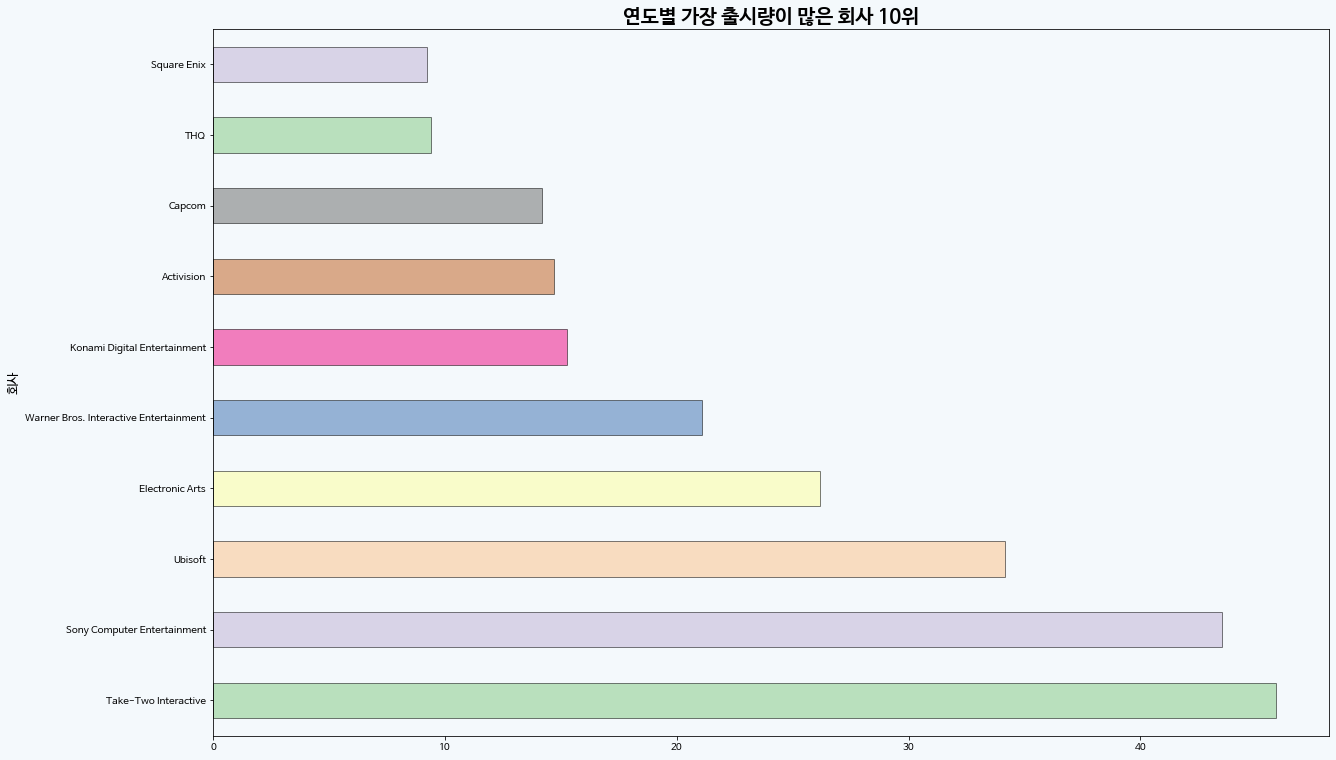

In [73]:
# 장르액션, 플랫폼 PS2, 출고지역 북미로 설정하여 어느 회사에서 배급, 출고해야 가장 좋은지 알아본다.
plt.figure(figsize=(20,13),facecolor='#F4F9FC')
new2=df.query('Genre=="Action" & Platform=="PS3" & NA_Sales!=0')
colors2 = sns.color_palette('Accent',len(new2))
q=new2.groupby('Publisher').Sales_total.sum().sort_values(ascending=False)[0:10].plot(kind='barh',color=colors2,edgecolor='Black',alpha=0.5)
q.set_title('연도별 가장 출시량이 많은 회사 10위',fontsize=20,fontweight='bold')
q.set_facecolor(color='#F4F9FC')
q.set_ylabel('회사',fontsize=13)

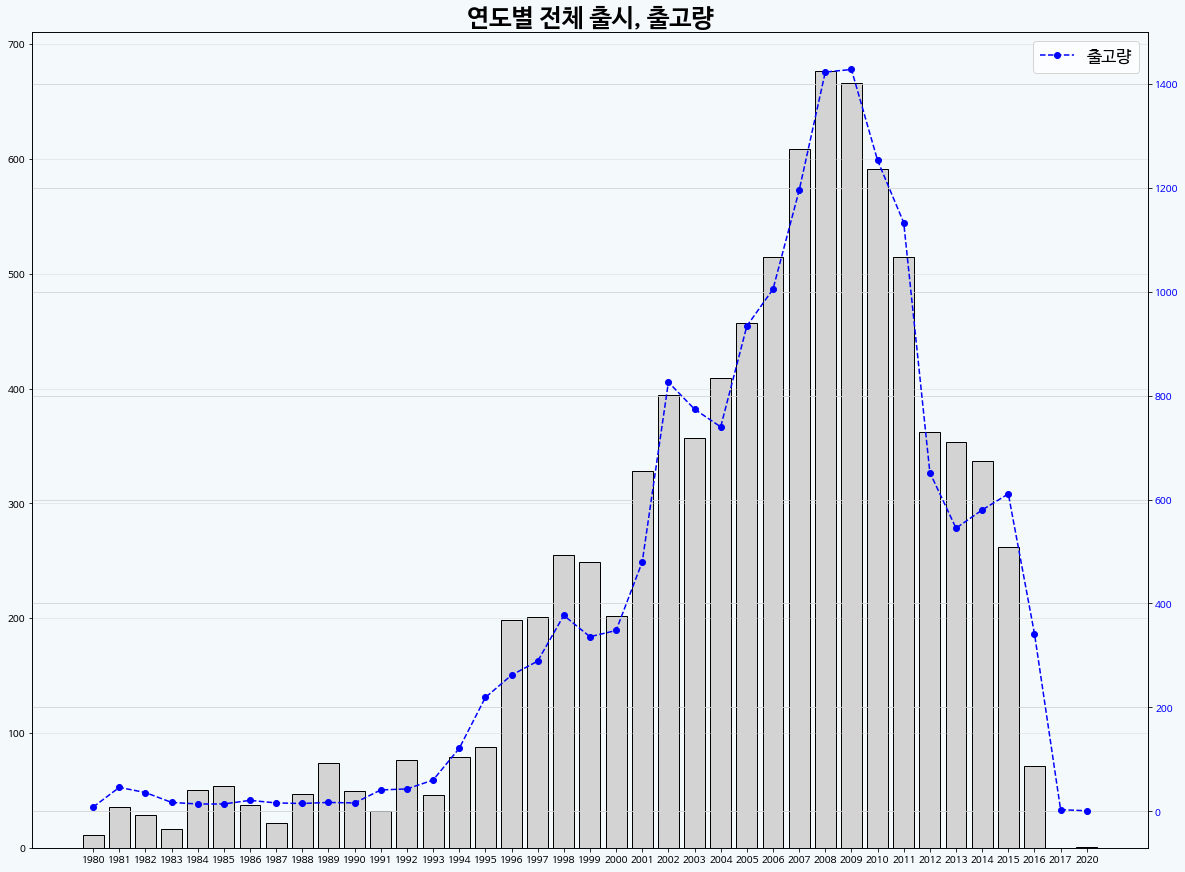

In [ ]:

year = df.groupby('Year').size().index
counts = df.groupby('Year').size().values
menass = df.groupby('Year')['Sales_total'].sum().values


fig = plt.figure(figsize=(20,15),facecolor='#F4F9FC') ## Figure 생성 
ax1 = fig.add_subplot() ## axes 생성
 
colors = 'lightgray' ## 바 차트 색상
 
xtick_label_position = list(range(len(year))) ## x축 눈금 라벨이 표시될 x좌표
ax1.set_xticks(xtick_label_position) ## x축 눈금 
ax1.set_xticklabels(year) ## x축 눈금 라벨
ax1.bar(xtick_label_position, menass, color=colors, edgecolor='black',label='출시량') ## 바차트 출력
ax1.set_facecolor(color='#F4F9FC')
ax1.grid(True, axis='y',color='lightgray',alpha=0.5)
 
color = 'blue'
ax2 = ax1.twinx() ## 새로운 axis 생성
ax2.plot(xtick_label_position, counts, color=color, linestyle='--', marker='o',label='출고량') ## 선 그래프 
ax2.tick_params(axis='y', labelcolor=color) ## 눈금 라벨 색상 지정
ax2.set_facecolor(color='#F4F9FC')
ax2.grid(True, axis='y',color='lightgray')

plt.title('연도별 전체 출시, 출고량', fontsize=25,fontweight='bold')
plt.legend(fontsize=17)
plt.show()

Text(0.5, 1.1, '지역별 출고량과 총 출고량의 상관관계')

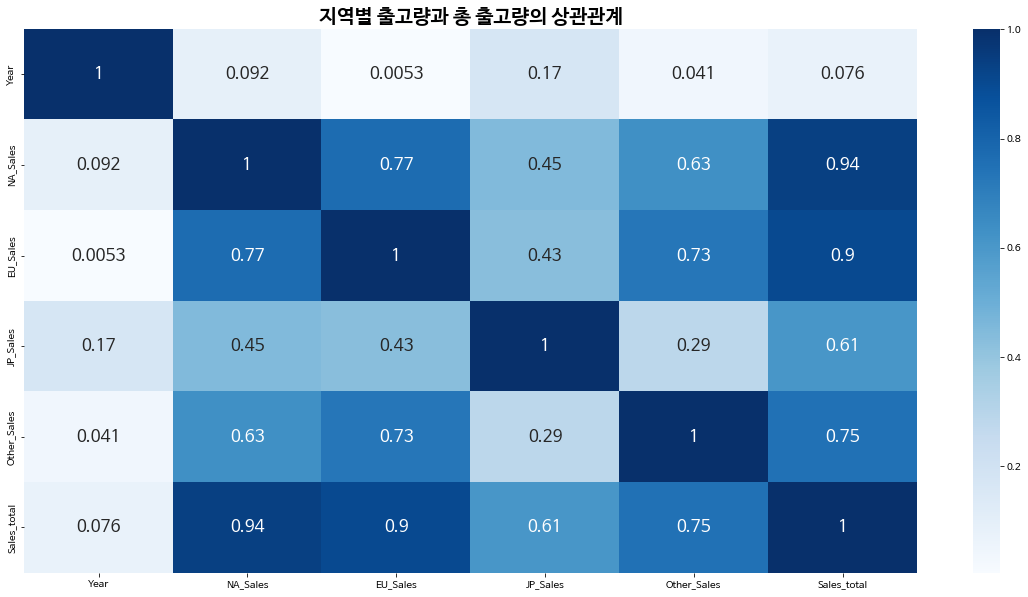

In [ ]:
plt.figure(figsize=(20,10))
a=sns.heatmap(df.corr().abs(),annot=True, cmap='Blues',annot_kws={'size':17})
a.set_facecolor(color='#F4F9FC')
plt.title('지역별 출고량과 총 출고량의 상관관계',fontsize=20,fontweight='bold',y=1.1)

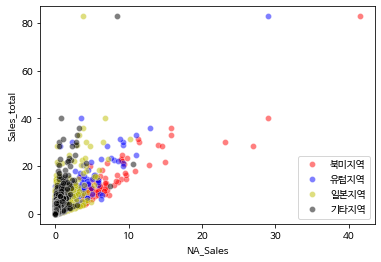

In [ ]:
# 북미지역과 유럽지역은 총 출고량과 양의 상관관계로 보임
sns.scatterplot(df.NA_Sales, df.Sales_total,color='r',label='북미지역',alpha=0.5)
sns.scatterplot(df.EU_Sales, df.Sales_total,color='B',label='유럽지역',alpha=0.5)
sns.scatterplot(df.JP_Sales, df.Sales_total,color='y',label='일본지역',alpha=0.5)
sns.scatterplot(df.Other_Sales, df.Sales_total,color='Black',label='기타지역',alpha=0.5)

In [ ]:
df["Multiplatform"] = df.duplicated(["Name"], keep=False) # 중복된 모든 행에 True 표시
df["Multiplatform"] = df["Multiplatform"].map({True: 1, False:0})
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Sales_total,Multiplatform
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04,1
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18,0
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02,0
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25,1
...,...,...,...,...,...,...,...,...,...,...,...
16236,Ice Age 2: The Meltdown,GC,2006,Platform,Vivendi Games,0.15,0.04,0.00,0.01,0.20,1
16237,Rainbow Islands: Revolution,PSP,2005,Action,Rising Star Games,0.01,0.00,0.00,0.00,0.01,0
16238,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0.79,1
16239,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,0.05,0.05,0.25,0.03,0.38,1


In [ ]:
df.Multiplatform.value_counts()

0    8584
1    7657
Name: Multiplatform, dtype: int64

### 결론
- 게임장르 : 액션
- 플랫폼 PS3 -> PS2와 일부분 호환 가능.
- 지역 : 북미
- 회사 take two interactive
- 다양한 플랫폼을 넘나들며 게임을 즐길 수 있는 크로스 플레이